# Basic Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import seaborn as sns
import fastai
#from fastai.text import *
from fastai.vision import *
from fastai.utils.mem import *
#from fastai.tabular import *
import scipy.signal as s
#import pyts
from itertools import chain 
from fastai.callbacks import *
import sklearn.metrics as smetrics
from scipy.stats import *

In [3]:
#Sets the random seed for everything being used with fastai.
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
path = Path("data/LFP_Prediction")

In [5]:
labels = pd.read_csv(path/"lfp_labels_new_data.csv", index_col = "start")

In [6]:
df = pd.read_csv(path/"model_fr_lfp_new.csv")
df = df.iloc[:len(labels)]

In [7]:
df["avgPNA"] = np.array([df.PNA1, df.PNA2, df.PNA3, df.PNA4, df.PNA5]).mean(0)
df["avgPNC"] = np.array([df.PNC1, df.PNC2, df.PNC3, df.PNC4, df.PNC5]).mean(0)
df["avgITN"] = np.array([df.ITN1, df.ITN2, df.ITN3, df.ITN4, df.ITN5]).mean(0)

In [8]:
#Class to store a single input item in the dataset.
#Stores a time series of every variable passed to it, does not contain the label.
#Shape (1, num_back, num_vars)
class TimeWindow(ItemBase):
    def __init__(self, time_window):
        time_window = np.copy(time_window)
        self.obj = (time_window)
        self.data = torch.Tensor(time_window)
        self.data = self.data[None]
        
    def to_one(self): return self.data
    
    def apply_tfms(self, tfms, **kwargs):
        return
    
    def __repr__(self):
        return "A time points plus"
    
#Contains all of the inputs for the data, as well as the capability to label the inputs.
class TimeWindowList(ItemList):
    _label_cls = CategoryList
    def __init__(self, items, num_back, data_input, **kwargs):
        self.its = items
        super().__init__(items, **kwargs)
        self.num_back = num_back
        self.data_input = data_input
        self.copy_new.append("data_input")
        self.copy_new.append("num_back")
        
    #Returns the input time series starting at index i.
    def get(self, i):
        i = self.items[i]
        return TimeWindow(self.data_input[i - self.num_back : i, :-1])
    
    def reconstruct(self, t:Tensor):
        return TimeWindow(t)
    
    def __len__(self):
        return len(self.items)
    
    #Called to create a LabelList for the data.
    def label_from_func(self, func:Callable, label_cls:Callable=None, **kwargs)->'LabelList':
        "Apply `func` to every input to get its label."
        return self._label_from_list([self.label_func(o) for o in range(0, len(self))], label_cls=label_cls, **kwargs)
    
    #Determines the label of input i based on the next_above list passed to this class.
    def label_func(self, i):
        return int(self.data_input[self.items[i], -1] == 1)

https://www.ijcai.org/Proceedings/2019/0932.pdf

In [9]:
class CNNModel(nn.Module):
    def __init__(self, out_size, num_features):
        super().__init__()
        self.num_features = num_features
        
        #Kernels of size (n, 1) to allow GradCam for individual variables/features.
        self.convs_2d = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = (9, 1), padding = (4, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size = (7, 1), stride = (2, 1), padding = (3, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.25),
            nn.Conv2d(128, 1, kernel_size = (1,1)),
            nn.ReLU(),
            nn.BatchNorm2d(1),
            nn.Dropout(0.4),
        )
        
        #Combines all features for GradCam over time.
        self.convs_1d = nn.Sequential(
            nn.Conv1d(num_features, 64, kernel_size = (5), padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Conv1d(64, 128, kernel_size = (5), stride = 2, padding = (2)),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
        )
        
        #Takes CNN features and turns them into the output.
        self.lins = nn.Sequential(
            nn.Linear(1280, 640),
            nn.ReLU(),
            nn.BatchNorm1d(640),
            nn.Dropout(),
            nn.Linear(640, 320),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Dropout(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.BatchNorm1d(160),
            nn.Dropout(),
            nn.Linear(160, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.Linear(32, out_size),
        )
        
    def forward(self, x):
        x = self.convs_2d(x)
        x = torch.squeeze(x, dim = 1)
        x = torch.transpose(x, 1, 2)
        x = self.convs_1d(x)
        x = torch.flatten(x, start_dim = 1)
        x = self.lins(x)
        return x

In [82]:
def bar_plot(ax, data, errors, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        j = 0
        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, yerr = errors[i][j], color=colors[i % len(colors)])
            j+= 1
        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

In [10]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,:-1].contiguous()).cuda()
        x = pred[:, :-1]
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction = "sum")/self.num_classes
    
    def get_weight(self, x, t): return None
    
class FocalLoss(BCE_Loss):
    def __init__(self, num_classes, alpha, gamma):
        super().__init__(num_classes)
        self.alpha = alpha
        self.gamma = gamma
        
    def get_weight(self,x,t):
        p = x.detach().sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        return w * (1-pt).pow(self.gamma)

In [11]:
def isNan(num):
    return num != num

#Returns accuracy where the truth value is 1 (peak is above).
def true_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 1
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

#Returns accuracy where the truth value is 0 (peak is bellow).
def false_acc(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    mask = targs == 0
    acc = float((input[mask]==targs[mask]).float().mean())
    if isNan(acc):
        return torch.Tensor([0.0]).cuda().mean()
    else:
        return (input[mask]==targs[mask]).float().mean()

kappa = KappaScore()
auc_roc = AUROC()

In [12]:
#Makes the train and test data sets out of the five folds.
def make_cross_data(splits, test_num, num_back, data_input, seed):
    valid_num = (test_num + 1) % 5
    
    #Concatenates together all of the splits that are not the test set.
    #The validation split is put first.
    inds = splits[valid_num]
    for i in range(5):
        if i != valid_num and i != test_num:
            inds = np.concatenate((inds, splits[i]))
            
    random_seed(seed, True)
    train_data = (TimeWindowList(inds, num_back, data_input)
                .split_by_idx(range(len(splits[0])))
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))
    
    #Creates the data out of the test split for evaluation.
    random_seed(seed, True)
    test_data = (TimeWindowList(splits[test_num], num_back, data_input)
                .split_none()
                .label_from_func(lambda x: x)
                .databunch(bs = 64, num_workers = 0))
    
    return train_data, test_data

In [13]:
#Performs given metrics on given model with the given data.
#Also performs kappa and auc_roc, as well as returns the confusion matrix.
def get_scores(learn, data, metrics):
    learn.data = data
    learn.loss_func = CrossEntropyFlat()
    interp = ClassificationInterpretation.from_learner(learn, DatasetType.Train)
    preds = np.array(interp.preds)
    kappa = smetrics.cohen_kappa_score(interp.y_true, preds.argmax(1))
    auc = smetrics.roc_auc_score(interp.y_true, preds[:, 1])
    return np.array([interp.confusion_matrix()] + [float(metric(interp.preds, interp.y_true)) for metric in metrics] + [kappa, auc])

In [14]:
#Performs 5 fold cross validation.
#Returns the evaluations for each fold.
def do_cross_valid(num_vars, indexes, data_input, num_back, train_metrics, test_metrics, wd, lr, epochs, base_name = None, num_start = 1, loss_func = None):
    res = []#Stores the evaluation scores for each fold.
    #Makes indexes divisible by 5 so it can be split evenly.
    indexes = np.array(indexes)[:len(indexes)-(len(indexes) % 5)]
    #Gets the five folds.
    splits = np.split(np.array(indexes), 5)
    
    for i in range(5):
        num_label = num_start + i
        train_data, test_data = make_cross_data(splits, i, num_back, data_input, num_label)
        
        #Creates the model.
        random_seed(num_label, True)
        if loss_func != None:
            learn = Learner(train_data, CNNModel(2, num_vars), loss_func = loss_func, metrics = train_metrics, wd = wd)
        else:
            learn = Learner(train_data, CNNModel(2, num_vars), metrics = train_metrics, wd = wd)
        
        #Decides where the model will be saved or if it should be saved.
        random_seed(num_label, True)
        if base_name != None:
            name = base_name + str(num_label)
        else:
            name = "model"
            
        #Used  for early stopping and saving the epoch with the best validation loss.
        callbacks = [EarlyStoppingCallback(learn, patience = 5),
                    SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=name)]
        
        #Fits the model.
        random_seed(num_label, True)
        learn.fit_one_cycle(epochs, lr, callbacks= callbacks)
        
        #Evaluates the model.
        res.append(get_scores(learn, test_data, test_metrics))
        
    return np.array(res)

In [15]:
#Normalizes given confusion matrix.
def normalize_cm(cm):
    cm = cm.astype(float)
    for i in range(len(cm)):
        cm[i] = cm[i] / cm[i].sum()
        
    return cm

In [16]:
#Draws the given confusion matrix.
def draw_cm(cm,title):
    fig,ax = plt.subplots()
    ax.imshow(cm, cmap = "Blues", interpolation = "nearest")
    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    # ... and label them with the respective list entries
    labs=[]
    for i in np.arange(0,cm.shape[0]):
        labs.append('{}'.format(i))
    ax.set_xticklabels(labs)
    ax.set_yticklabels(labs)
    ax.set_ylabel('true')
    ax.set_xlabel('pred')
    ax.set_title(title)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, np.round(cm[i, j],2),
                       ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

In [17]:
#Displays the results of the cross_validation.
def display_results(results):
    cm = np.array([normalize_cm(result[0]) for result in results]).mean(0)
    draw_cm(cm, "Confusion Matrix")
    print("Accuracy:", results[:, 1].mean())
    print("KappaScore:", results[:, 2].mean())
    print("AUC_ROC:", results[:, 3].mean())

In [18]:
#Metrics calculated each epoch during training.
train_metrics = [accuracy, true_acc, false_acc, kappa]

#Metrics used for evaluation of each fold.
test_metrics = [accuracy]

In [19]:
columns = df.columns
columns

Index(['PNA1', 'PNA2', 'PNA3', 'PNA4', 'PNA5', 'PNC1', 'PNC2', 'PNC3', 'PNC4',
       'PNC5', 'ITN1', 'ITN2', 'ITN3', 'ITN4', 'ITN5', 'rawLFP', 'filtLFP',
       'hilbLFP', 'avgPNA', 'avgPNC', 'avgITN'],
      dtype='object')

Code for removing input that includes a burst which is our base at the moment.

In [24]:
filt = np.array(df.filtLFP)
hilb = np.array(df.hilbLFP)
raw = np.array(df.rawLFP)
peaks_above = np.array(labels.peaks_above)
num_back = 40

In [25]:
b, a = s.butter(2, [50, 80], btype = "bandstop", fs = 1000)

In [26]:
noise = s.filtfilt(b, a, raw)

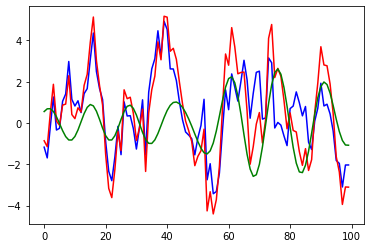

In [28]:
plt.plot(noise[:100], color = "blue")
plt.plot(raw[:100], color = "red")
plt.plot(filt[:100], color = "green")

In [29]:
is_peak_burst = np.zeros(len(df))
peaks = s.argrelextrema(filt, np.greater)[0]

In [30]:
for i in range(len(peaks)):
    peak = peaks[i]
    if is_peak_burst[peak] == 0 and peaks_above[peak] >= 3:
        for j in range(1, peaks_above[peak] + 1):
            is_peak_burst[peaks[i + j]] = 1

In [31]:
#Percent of peaks part of a gamma burst.
len(np.where(is_peak_burst == 1)[0]) / len(peaks) * 100

4.807036166502388

In [32]:
#Number of peaks part of a burst.
len(np.where(is_peak_burst == 1)[0])

634

In [33]:
includes_burst = []
for i in range(len(df)):
    if 1 in is_peak_burst[max(0, i - 40):i]:
        includes_burst.append(True)
    else:
        includes_burst.append(False)
        
includes_burst = np.array(includes_burst)

# XAI

## Failure Analysis

In [34]:
#Stores all input except for filtLFP and hilbLFP.
data_input = np.stack([df[columns[i]] for i in range(16)] + [df[columns[i]] for i in range(-3, 0)]  + [labels.next_above], axis = -1)

In [112]:
extra_data_input = np.stack([df[columns[i]] for i in range(len(columns))]  + [noise, abs(noise)] + [labels.next_above], axis = -1)

In [36]:
#Gets the indexes in data_input where it is only 3 or less ms until the next peak 
#and the input does not include a burst.
#Right now only using df[:-30000] so test set is kept, don't know if necessary.
indexes = np.array([i for i in range(100, len(df) - 30000) 
                    if labels.time_until_peak[i] <= 3 and labels.time_until_peak[i] >= 1 and includes_burst[i] == False])

In [37]:
num_true = len(np.where(np.array(labels.next_above[indexes]) == 1)[0])
num_true

3307

In [38]:
#Percent of input that is labeled as above threshold.
percent_true = (num_true / len(indexes)) * 100

In [39]:
#Was about 13.4% before removals.
percent_true

10.568196344113511

In [40]:
len(indexes)

31292

In [41]:
loss_f = FocalLoss(2, percent_true / 100, 2)

In [42]:
num_vars = 19

In [43]:
random_seed(1, True)
train_data = (TimeWindowList(indexes, num_back, data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [113]:
random_seed(1, True)
extra_data = (TimeWindowList(indexes, num_back, extra_data_input)
            .split_by_idx(range(10000))
            .label_from_func(lambda x: x)
            .databunch(bs = 64, num_workers = 0))

In [45]:
random_seed(1, True)
learn = Learner(train_data, CNNModel(2, num_vars), metrics = [accuracy, true_acc, false_acc, kappa],
                loss_func = loss_f, wd = 1e-4)

In [46]:
#learn.save("model")
learn.load("br_model")

Learner(data=DataBunch;

Train: LabelList (21292 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (10000 items)
x: TimeWindowList
A time points plus,A time points plus,A time points plus,A time points plus,A time points plus
y: CategoryList
0,0,0,1,1
Path: .;

Test: None, model=CNNModel(
  (convs_2d): Sequential(
    (0): Conv2d(1, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25)
    (4): Conv2d(64, 128, kernel_size=(7, 1), stride=(2, 1), padding=(3, 0))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25)
    (8): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [47]:
learn.loss_func = CrossEntropyFlat()
interp = ClassificationInterpretation.from_learner(learn)

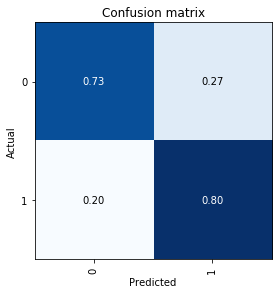

In [48]:
interp.plot_confusion_matrix(normalize = True)

In [49]:
next_peaks = np.array(labels.next_peak)[indexes]

In [50]:
actual = np.array(interp.y_true)

In [51]:
preds = np.argmax(np.array(interp.preds), 1)

In [52]:
correctness = preds == actual

In [53]:
correct_true = [i for i in range(len(actual)) if actual[i] == 1 and correctness[i]]

In [54]:
incorrect_true = [i  for i in range(len(actual)) if actual[i] == 1 and not correctness[i]]

In [55]:
correct_false = [i for i in range(len(actual)) if actual[i] == 0 and correctness[i]]

In [56]:
incorrect_false = [i for i in range(len(actual)) if  actual[i] == 0 and not correctness[i]]

In [57]:
next_peaks[correct_true].mean()

2.3528

In [58]:
next_peaks[incorrect_true].mean()

2.209509478672986

In [59]:
f_oneway(next_peaks[correct_true], next_peaks[incorrect_true])

F_onewayResult(statistic=50.61675046587469, pvalue=2.0537823565623295e-12)

In [60]:
next_peaks[correct_false].mean()

0.9113268736213235

In [61]:
next_peaks[incorrect_false].mean()

1.3609744027488546

In [62]:
f_oneway(next_peaks[correct_false], next_peaks[incorrect_false])

F_onewayResult(statistic=1786.7165903356106, pvalue=0.0)

In [114]:
tp_data = np.array([np.array(extra_data.valid_ds[i][0].data[0]) for i in correct_true])

In [115]:
fn_data = np.array([np.array(extra_data.valid_ds[i][0].data[0]) for i in incorrect_true])

In [116]:
tn_data = np.array([np.array(extra_data.valid_ds[i][0].data[0]) for i in correct_false])

In [117]:
fp_data = np.array([np.array(extra_data.valid_ds[i][0].data[0]) for i in incorrect_false])

In [144]:
datas = np.array([tp_data, fn_data, tn_data, fp_data])

In [119]:
names = ["True Positives", "False Negatives", "True Negatives", "False Positives"]

In [100]:
t_p_values = [f_oneway(tp_data[:, i, 15], fn_data[:, i, 15]) for i in range(40)]

In [120]:
tp_means = np.array([tp_data[:, i, :].mean(0) for i in range(40)])
fn_means = np.array([fn_data[:, i, :].mean(0) for i in range(40)])
tn_means = np.array([tn_data[:, i, :].mean(0) for i in range(40)])
fp_means = np.array([fp_data[:, i, :].mean(0) for i in range(40)])

In [149]:
means = np.array([tp_means, fn_means, tn_means, fp_means])

In [121]:
tp_stds = np.array([tp_data[:, i, :].std(0) for i in range(40)])
fn_stds = np.array([fn_data[:, i, :].std(0) for i in range(40)])
tn_stds = np.array([tn_data[:, i, :].std(0) for i in range(40)])
fp_stds = np.array([fp_data[:, i, :].std(0) for i in range(40)])

In [150]:
stds = np.array([tp_stds, fn_stds, tn_stds, fp_stds])

### Bar Plots

In [134]:
relevant = [15, 16, 18, 19, 20, 21, 22]

In [127]:
cols = list(columns) + ["noise"] + ["absNoise"]

In [139]:
np.array(cols)[relevant]

array(['rawLFP', 'filtLFP', 'avgPNA', 'avgPNC', 'avgITN', 'noise', 'absNoise'], dtype='<U8')

True Positives vs. False Negatives


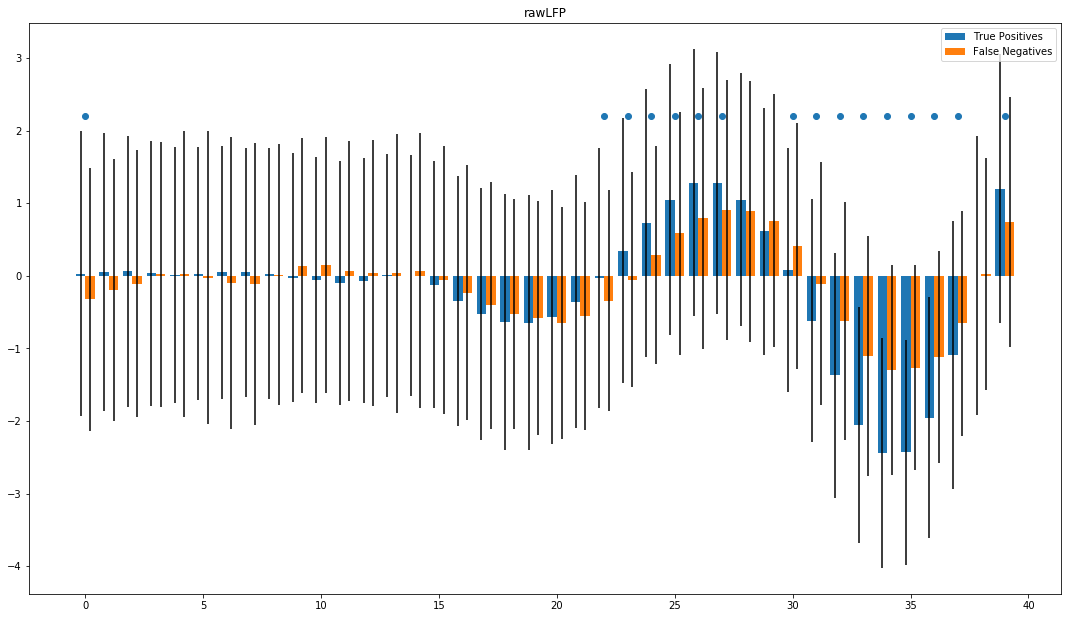

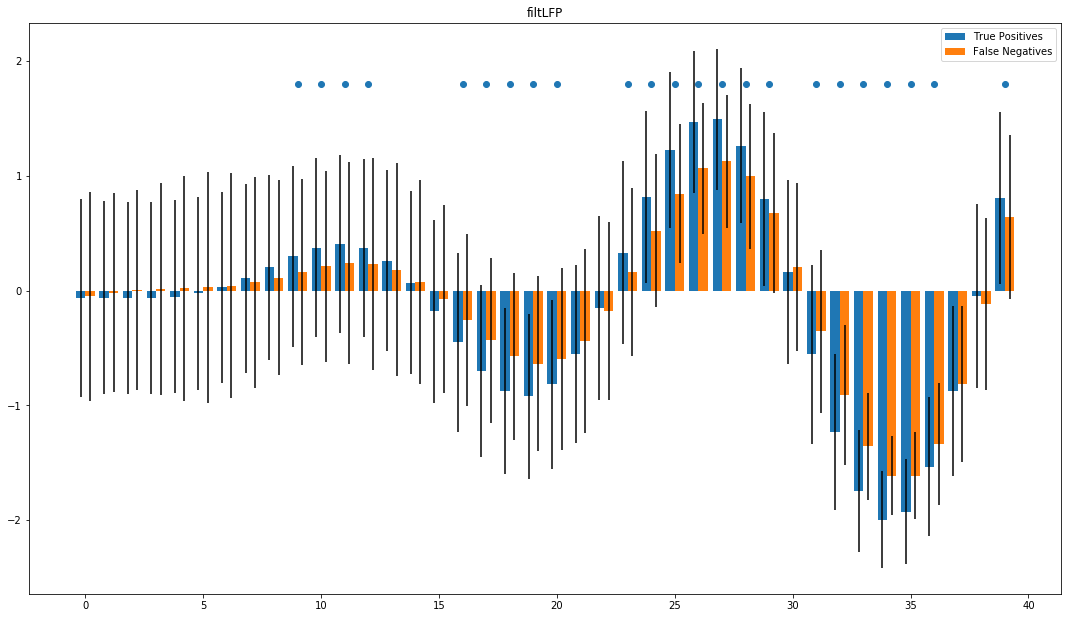

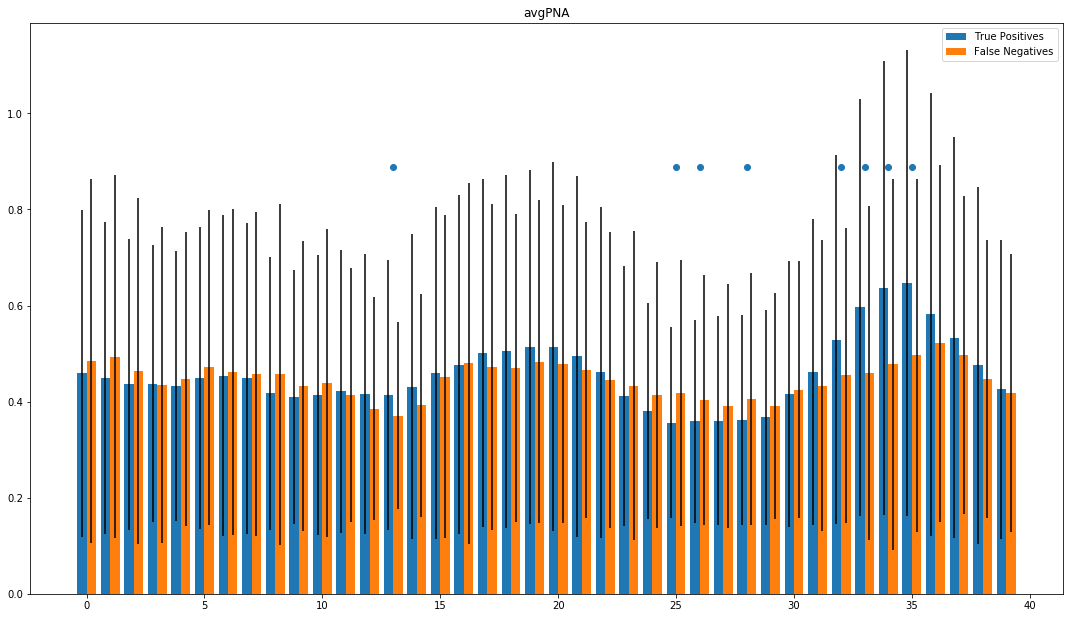

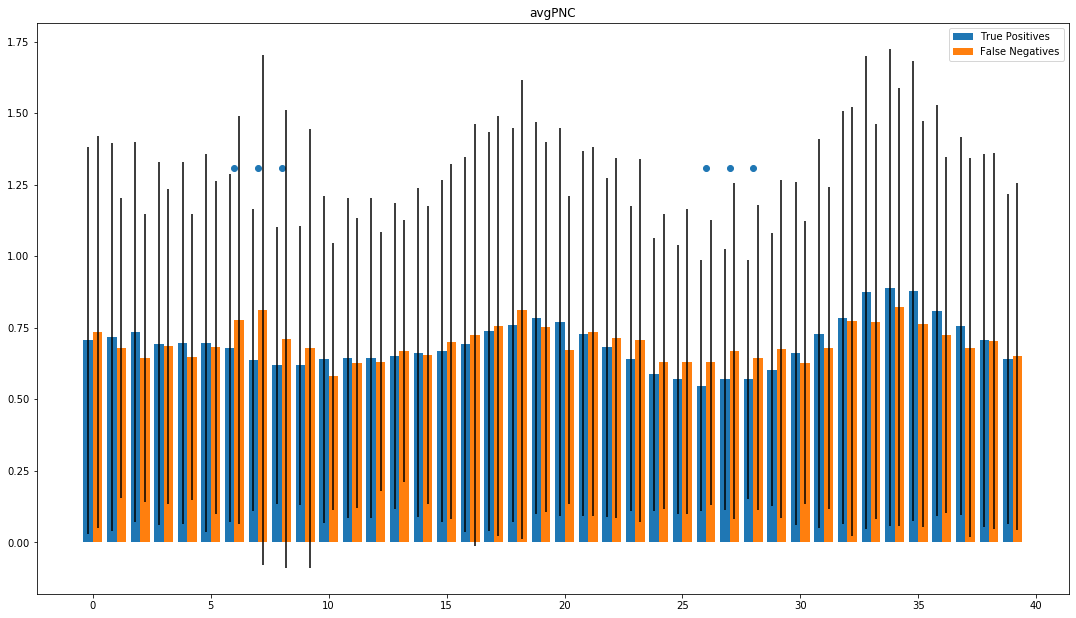

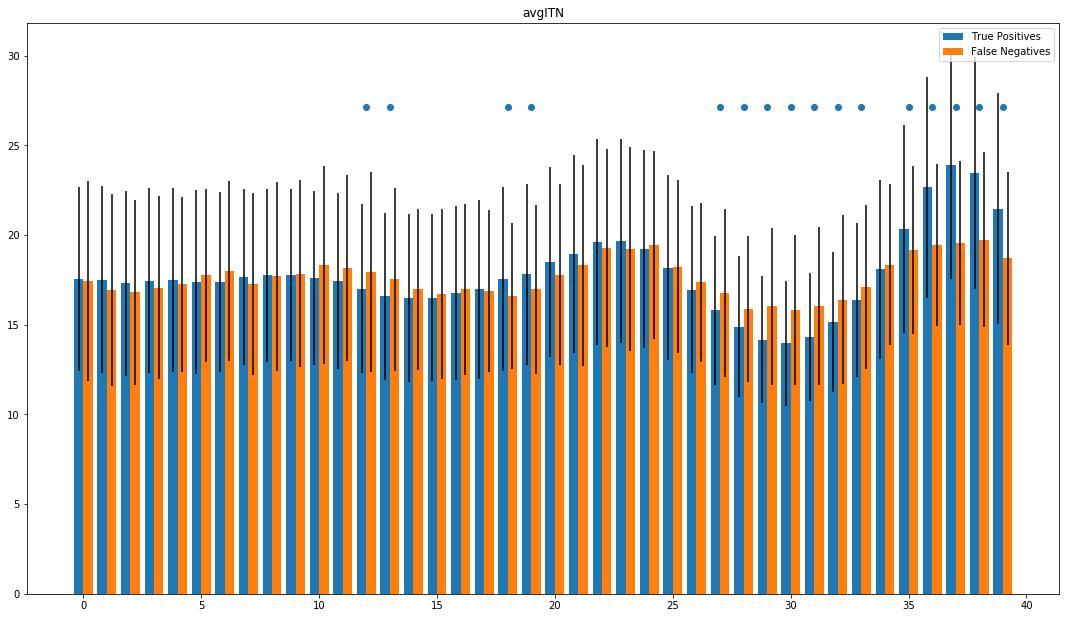

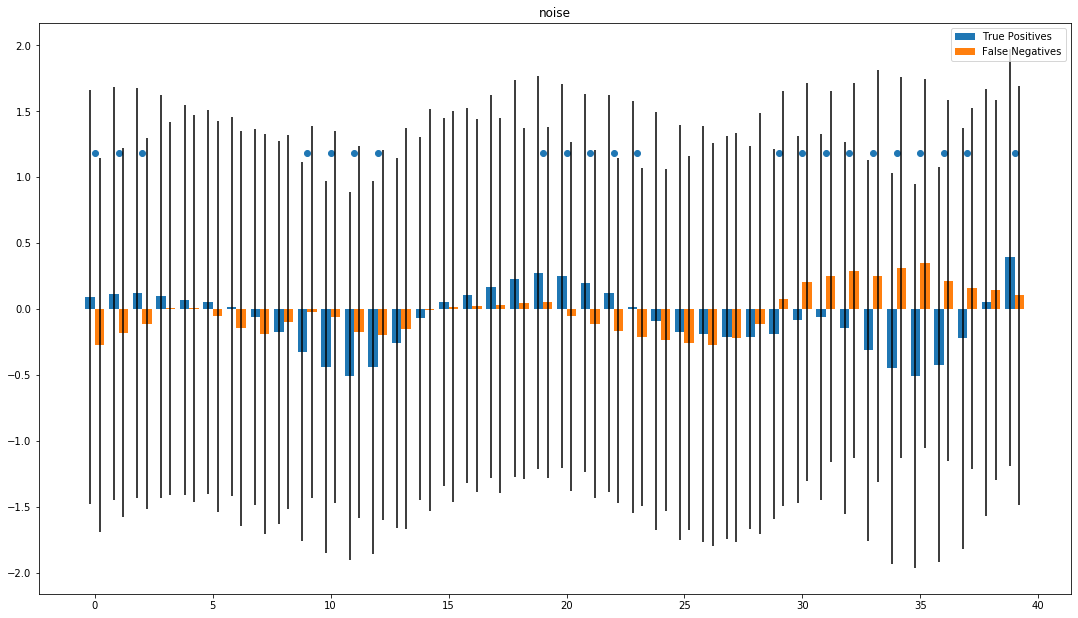

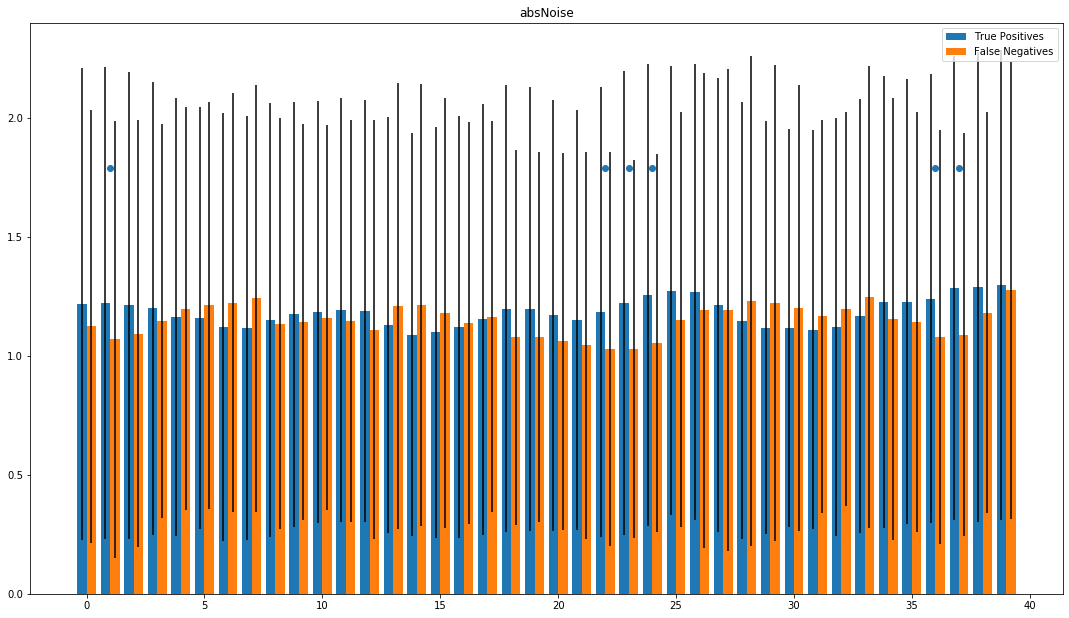

True Positives vs. True Negatives


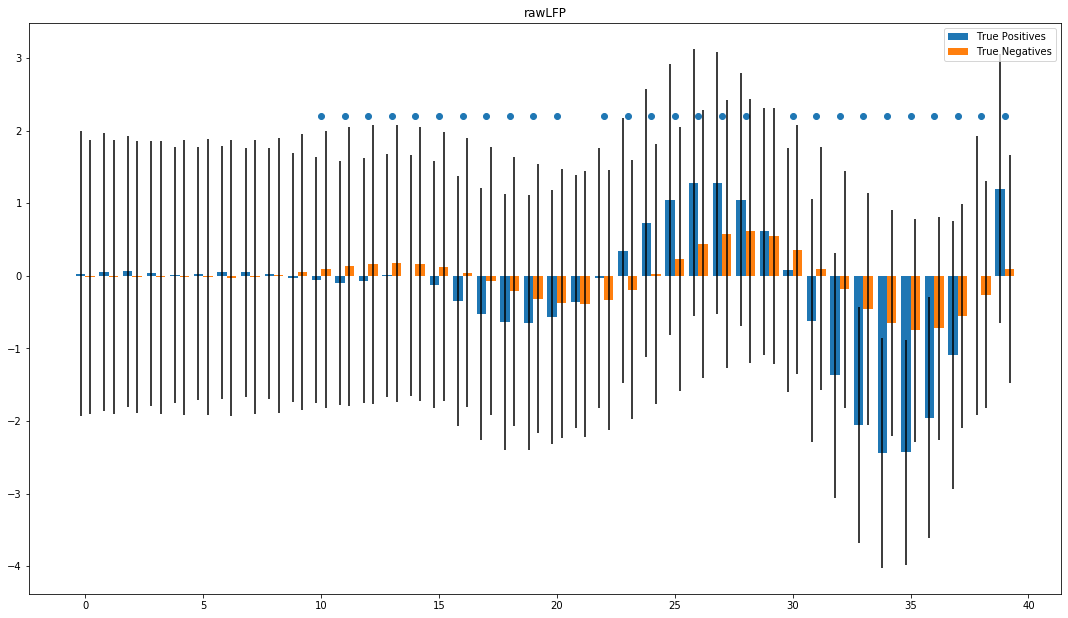

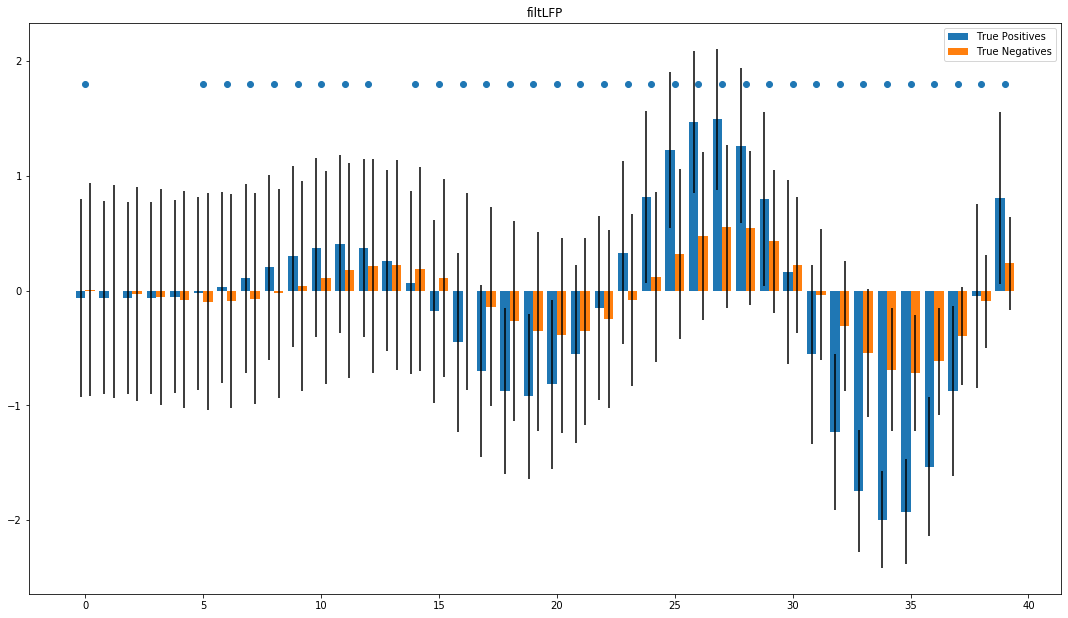

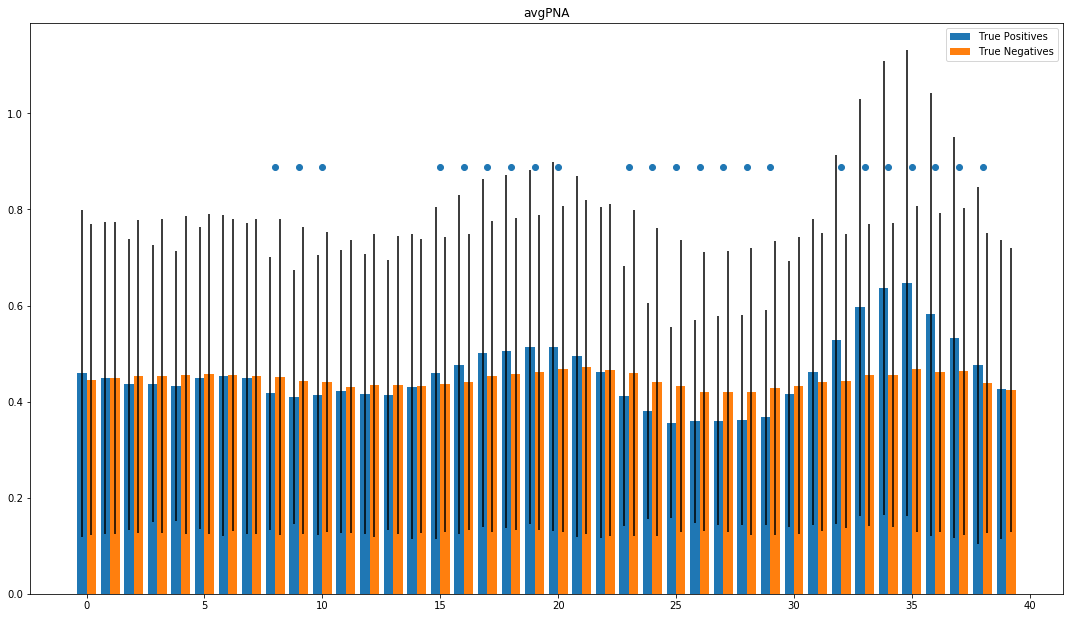

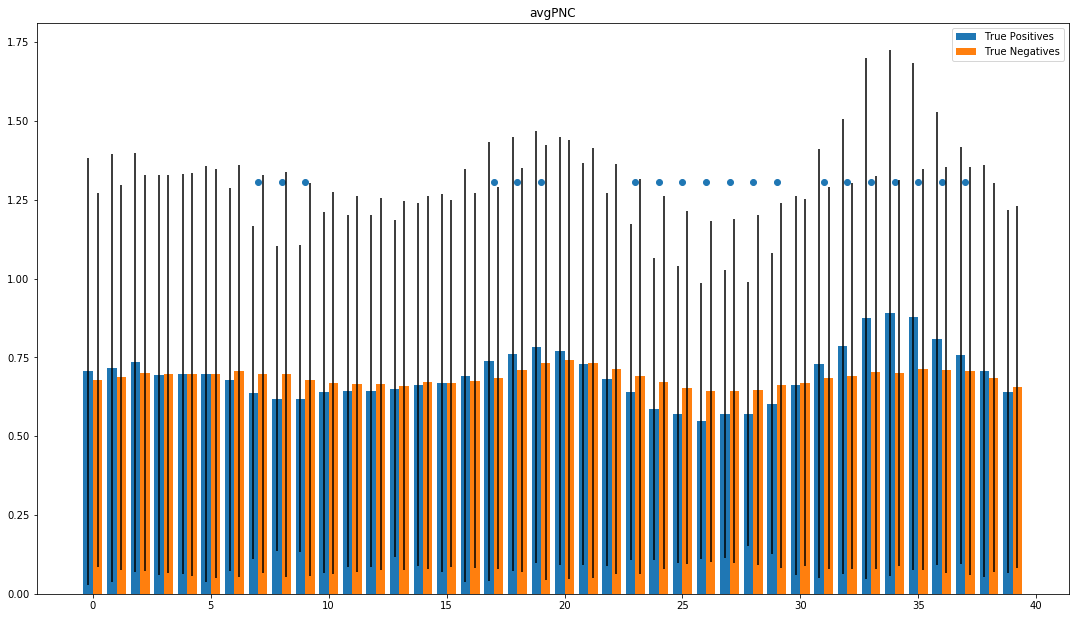

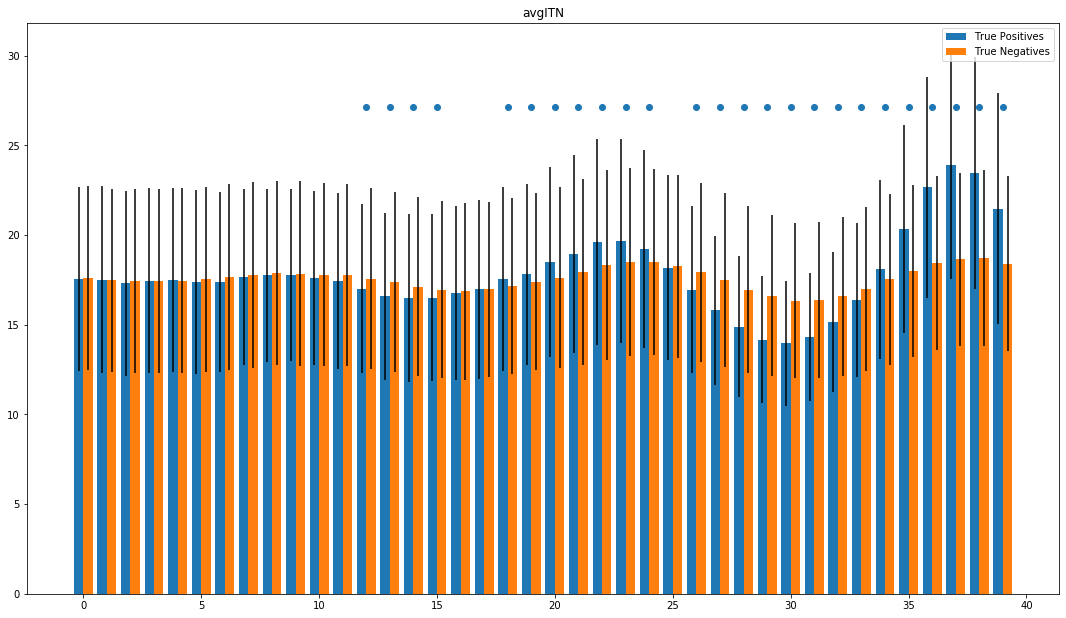

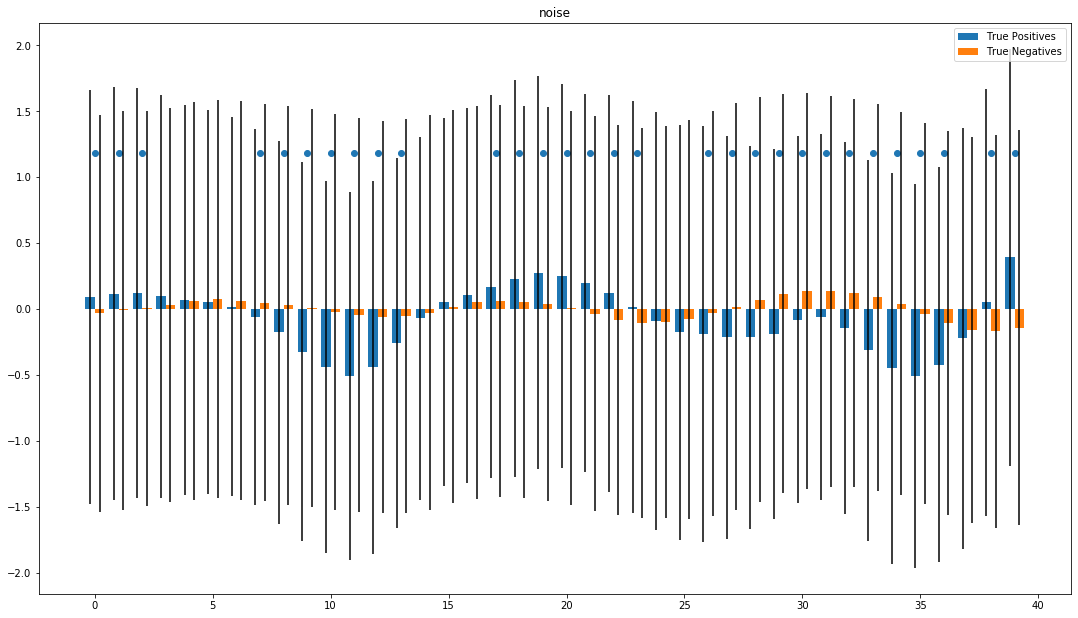

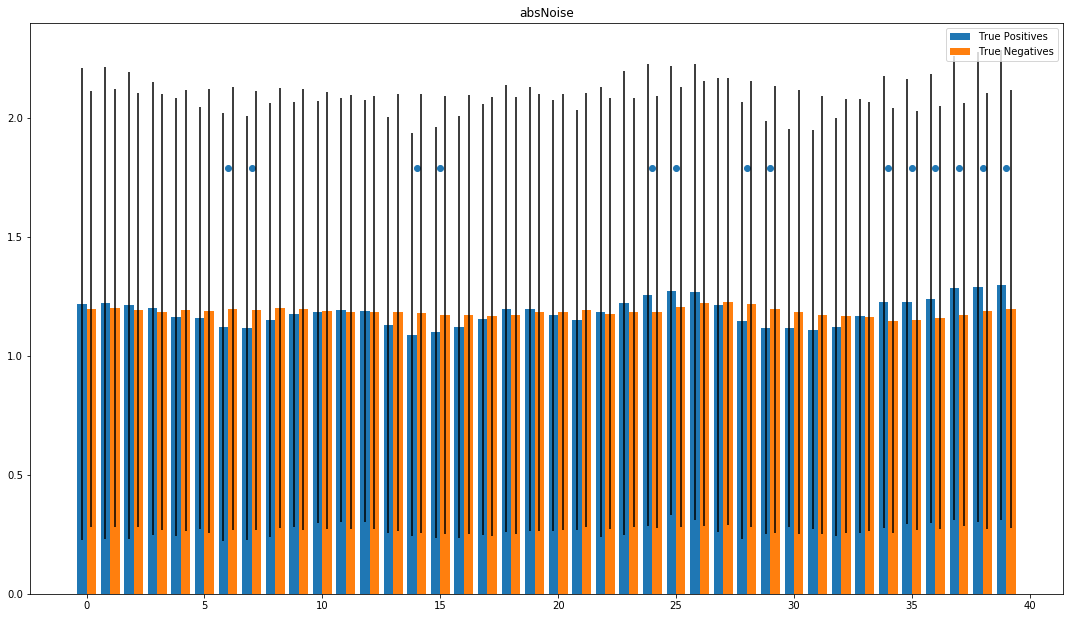

True Positives vs. False Positives


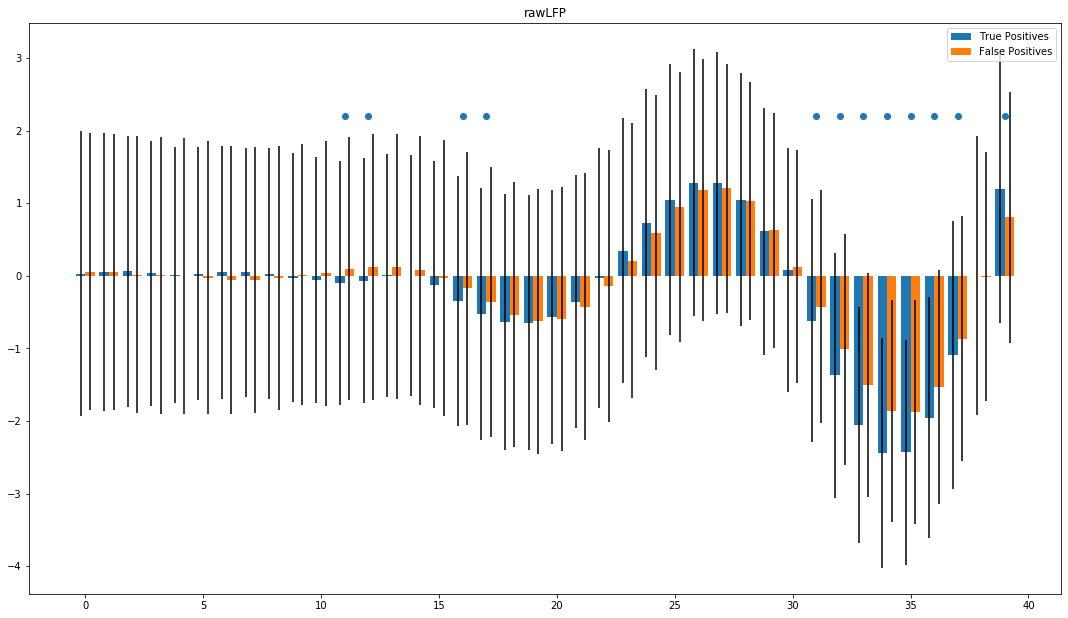

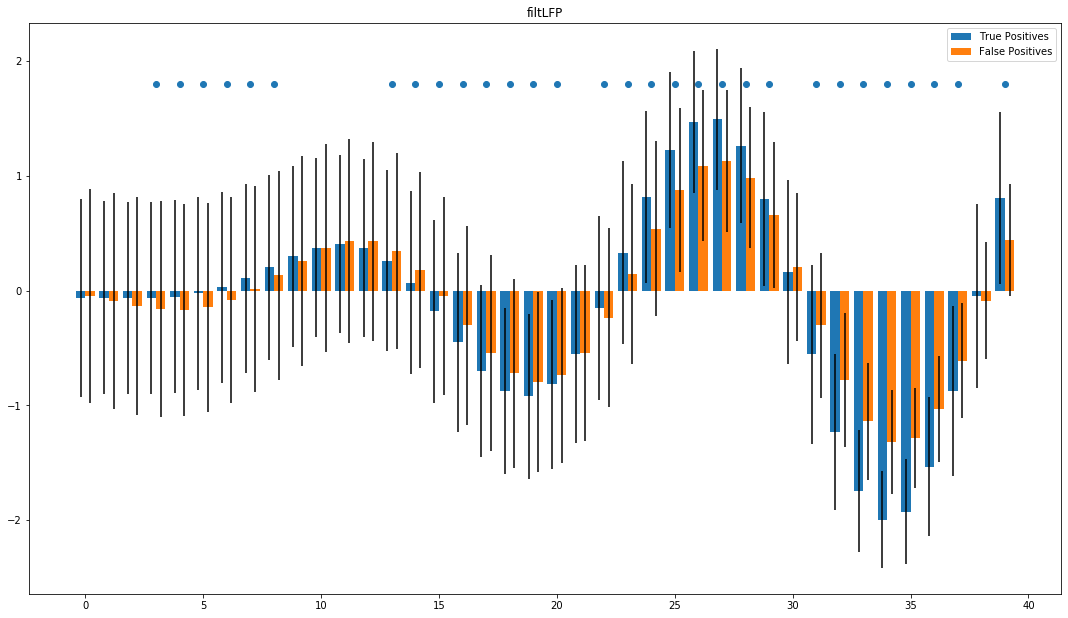

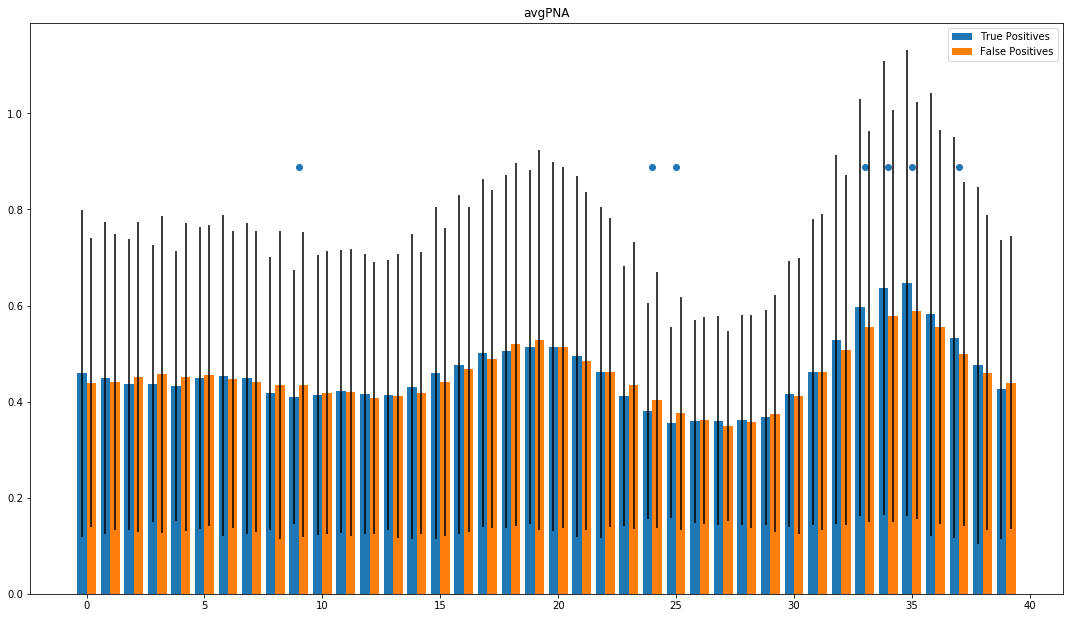

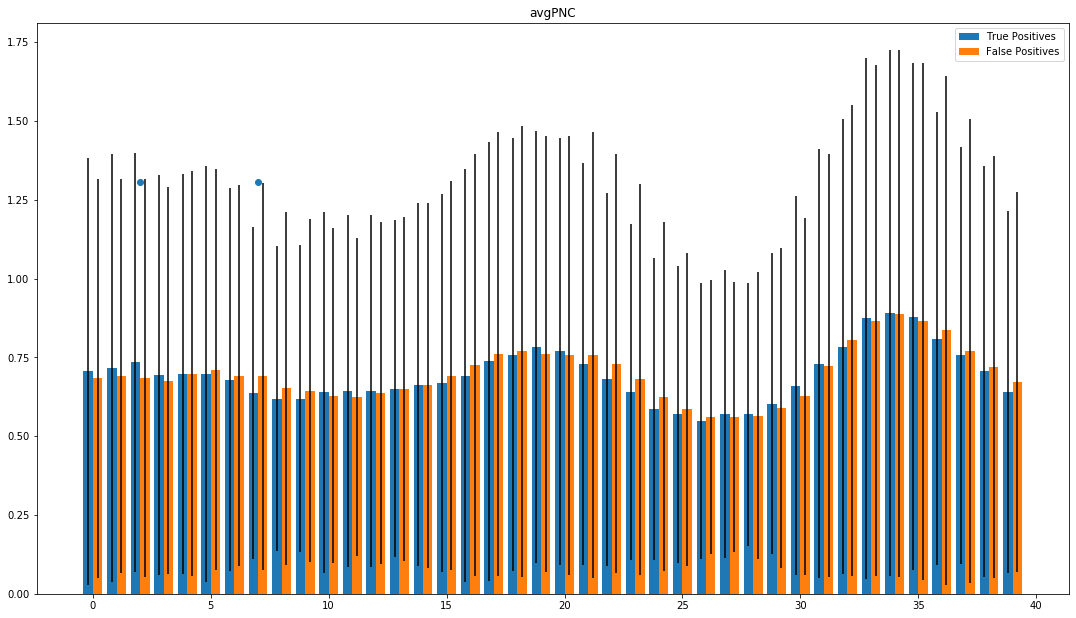

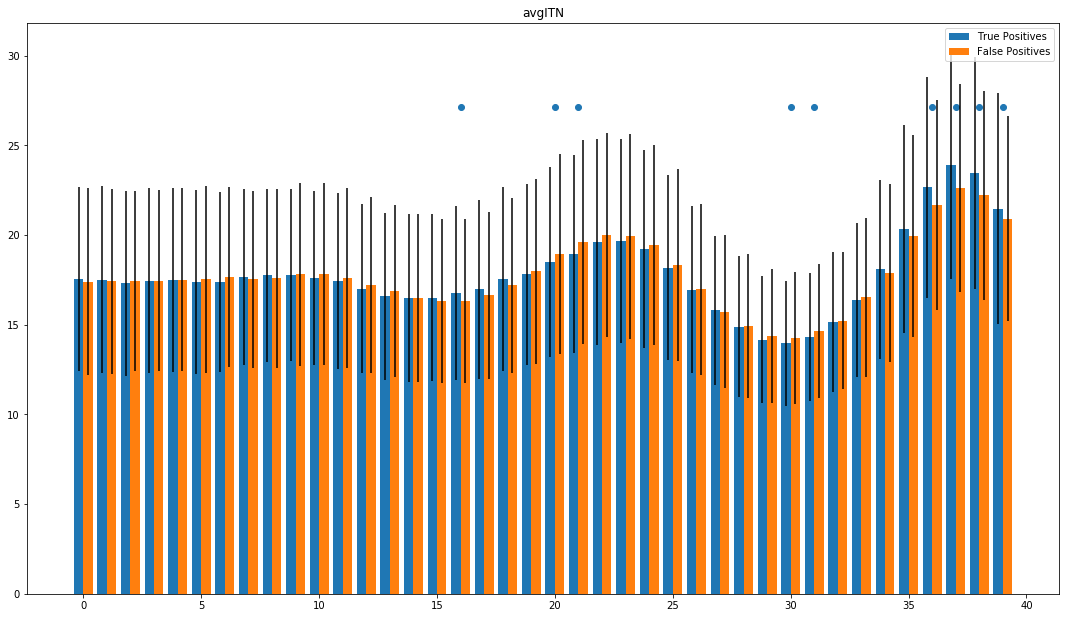

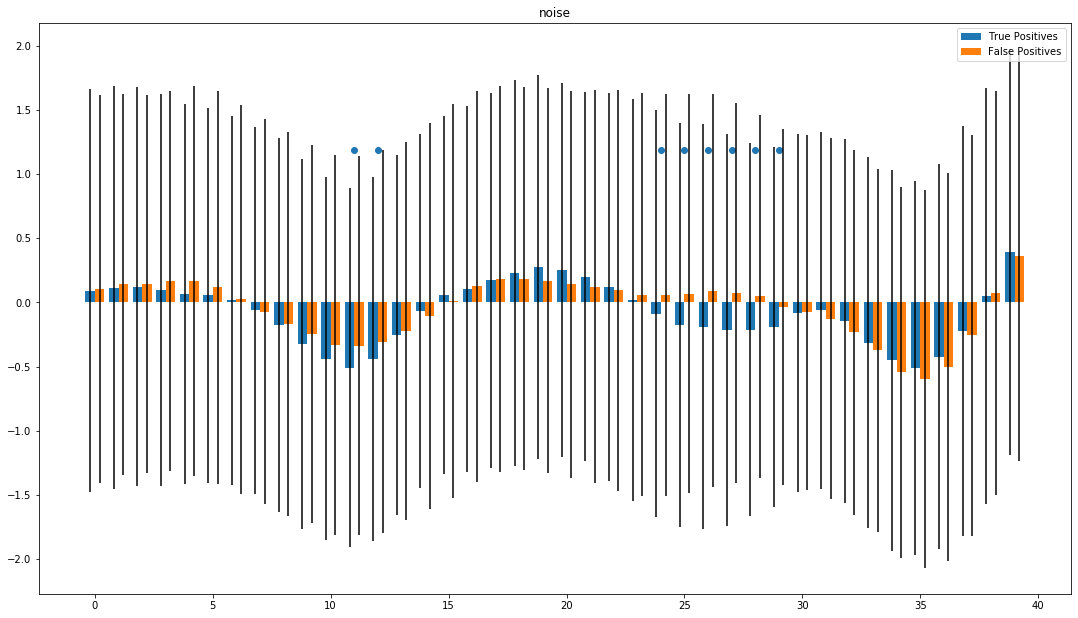

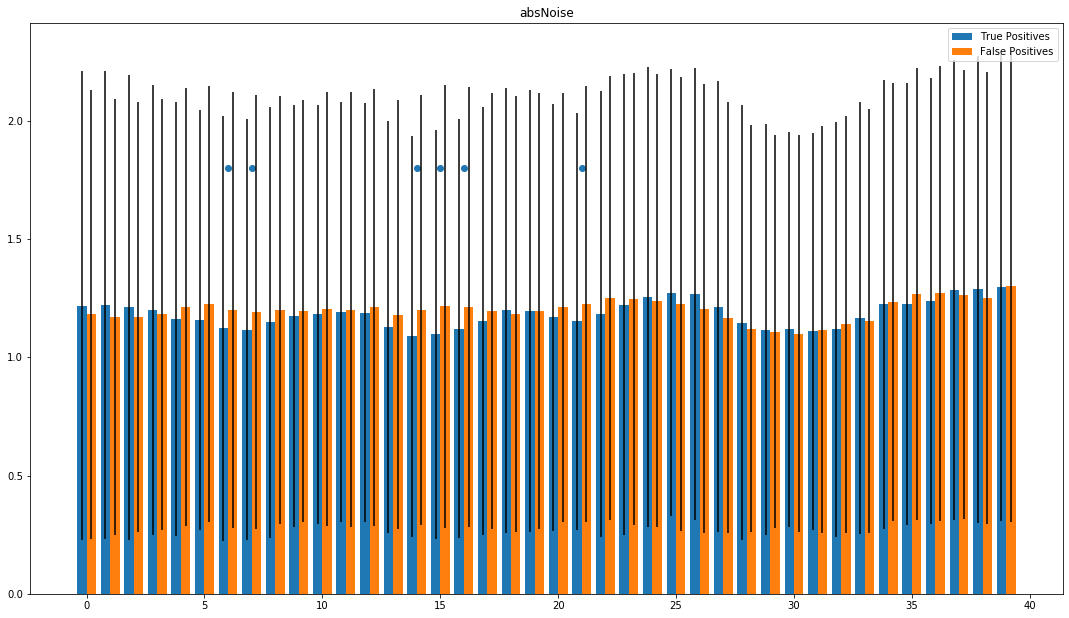

False Negatives vs. True Negatives


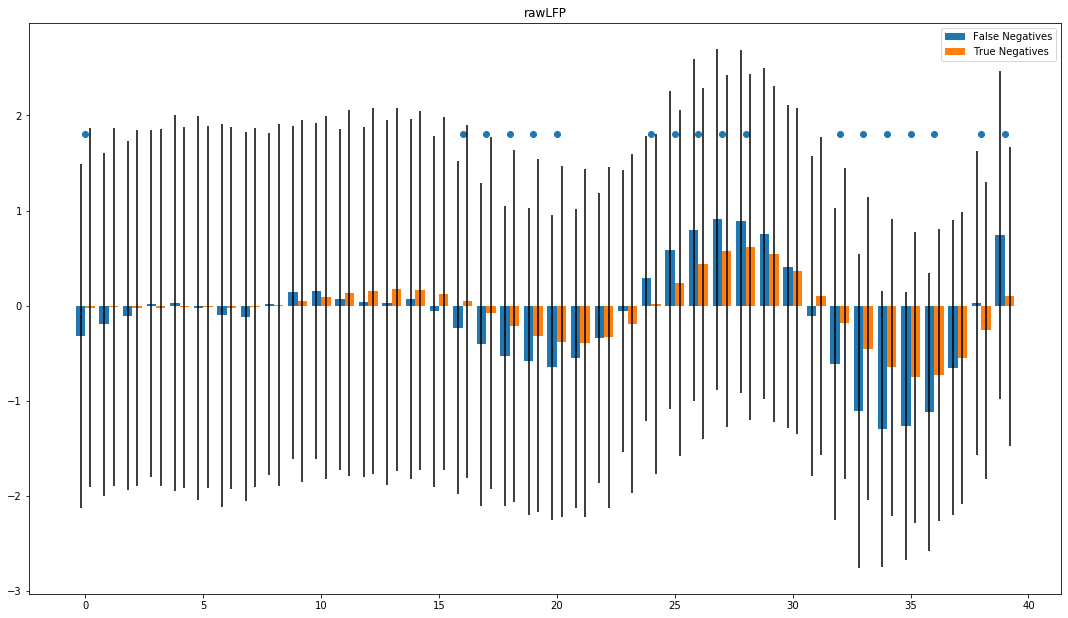

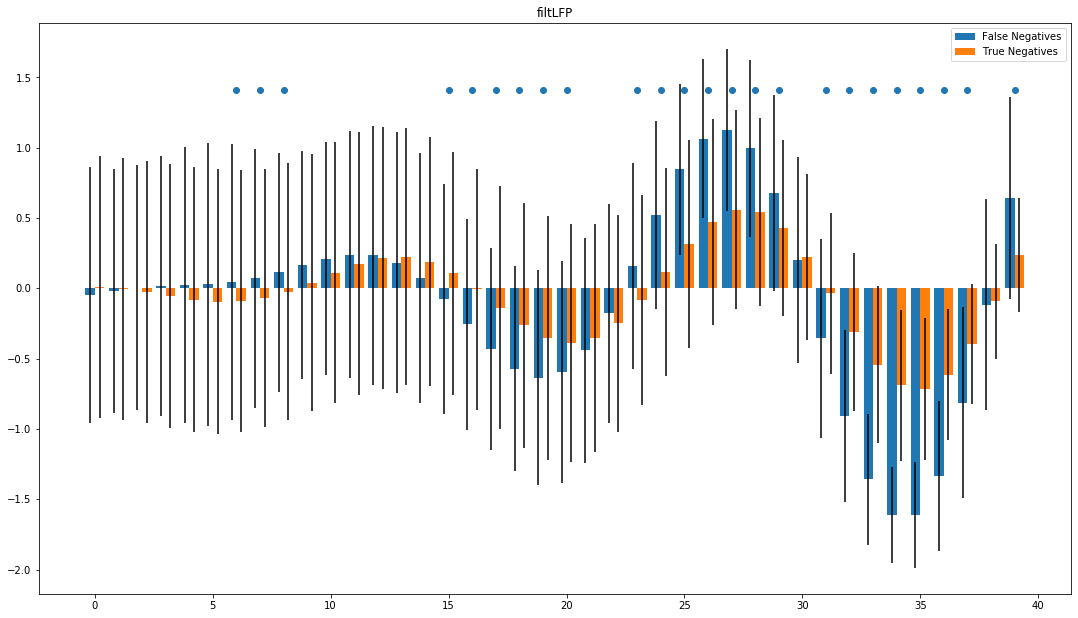

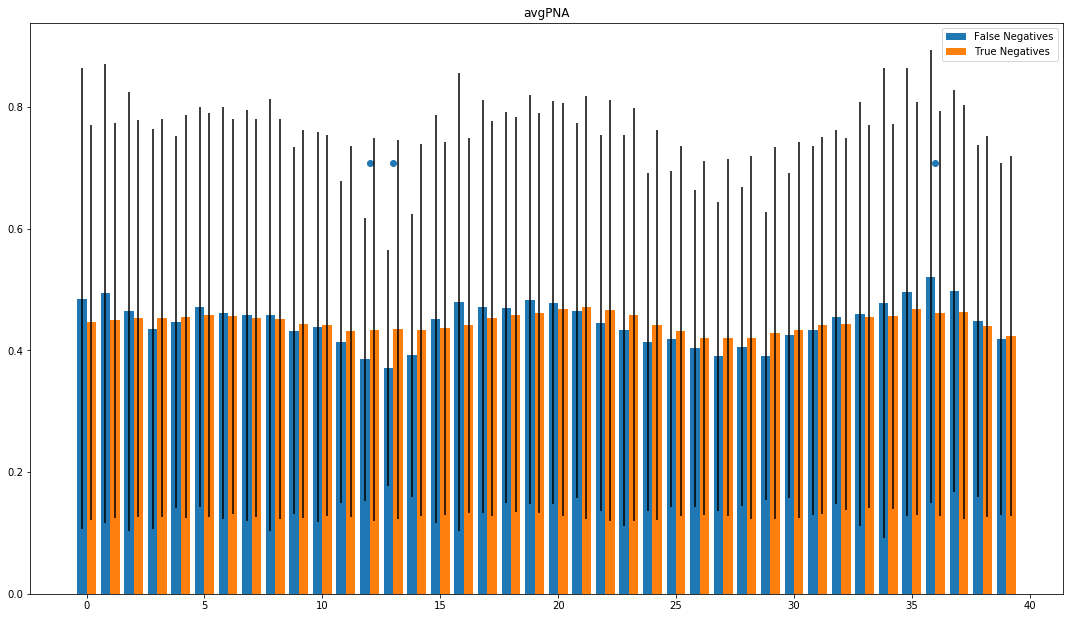

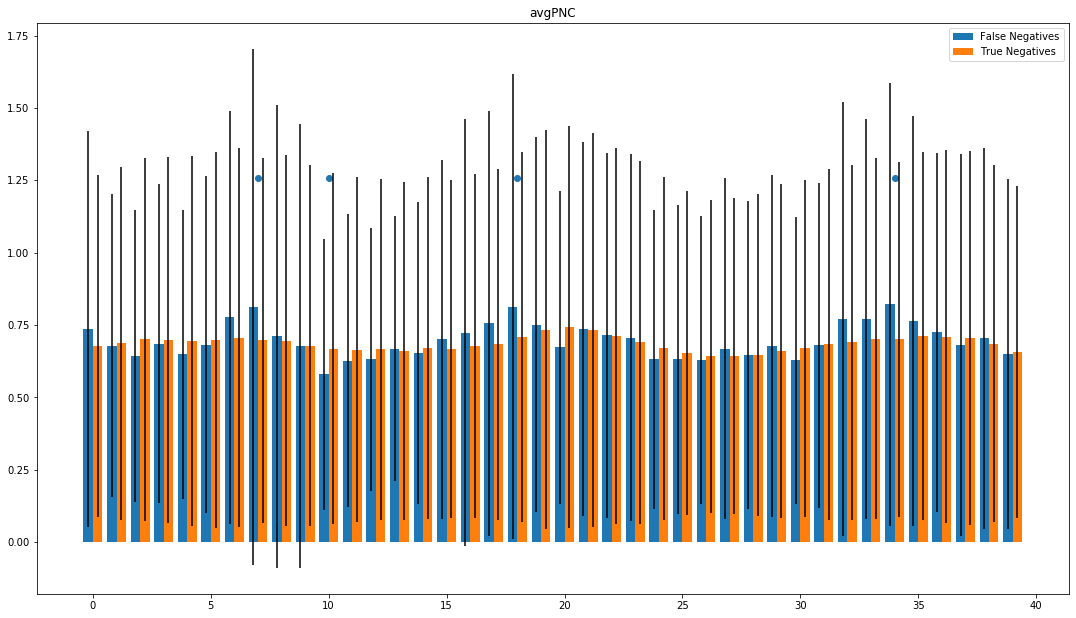

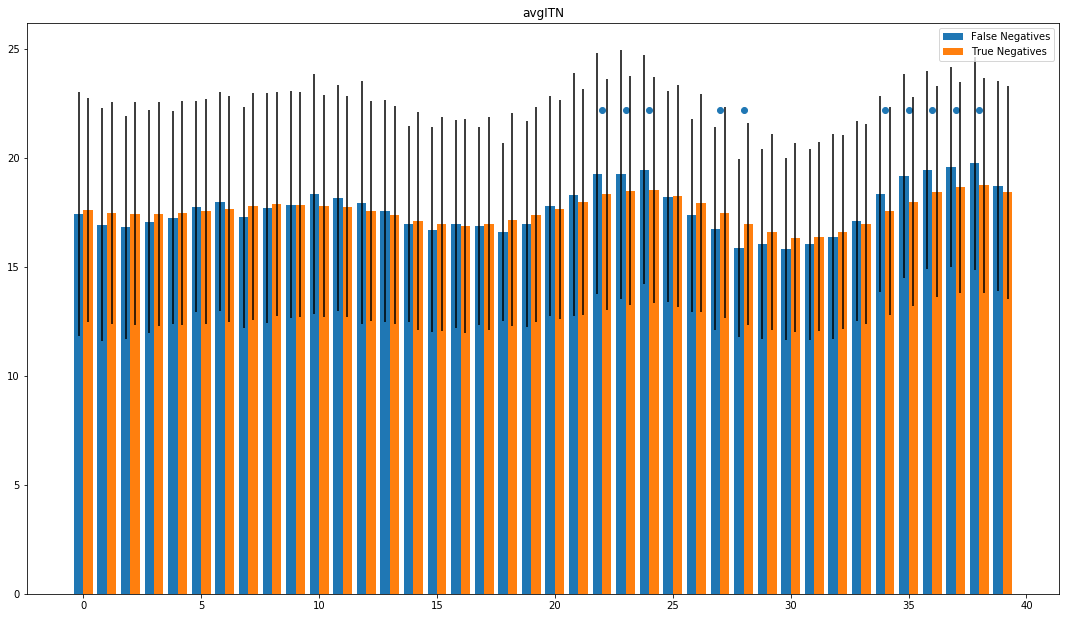

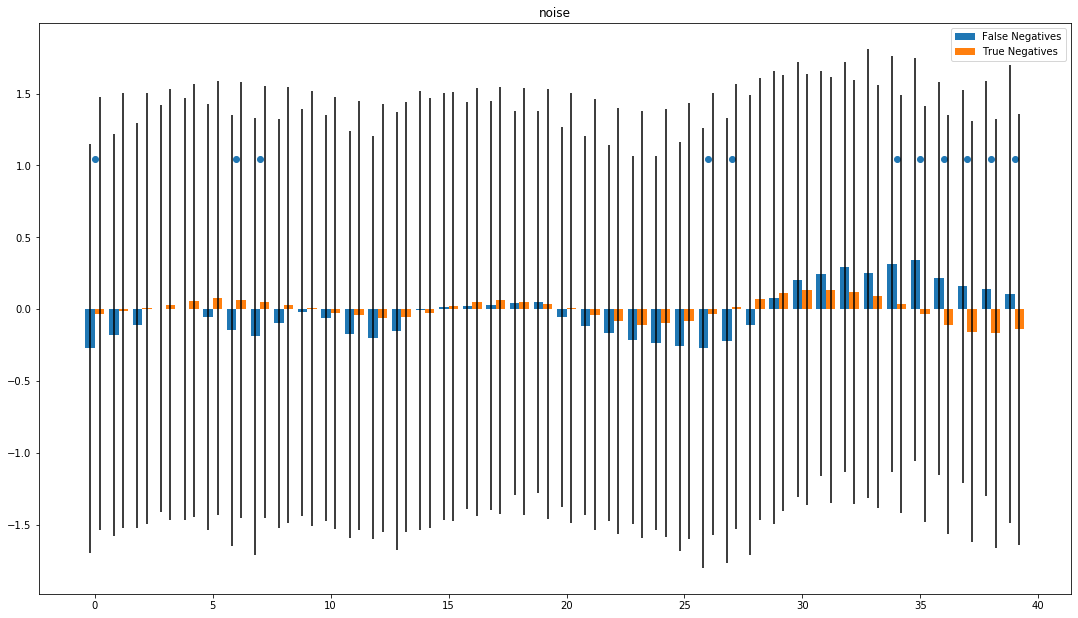

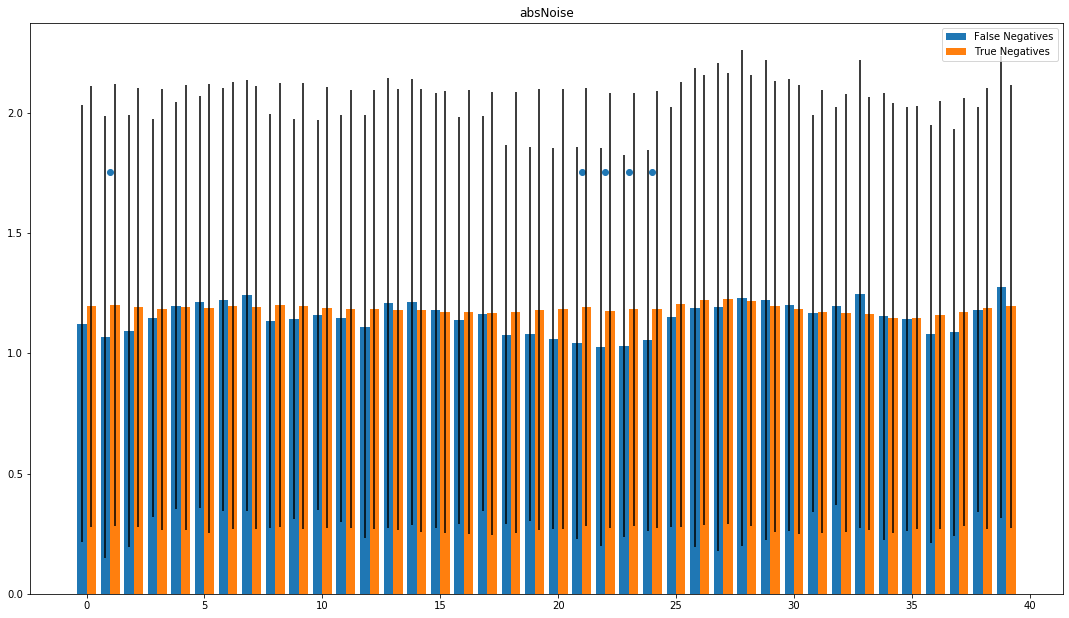

False Negatives vs. False Positives


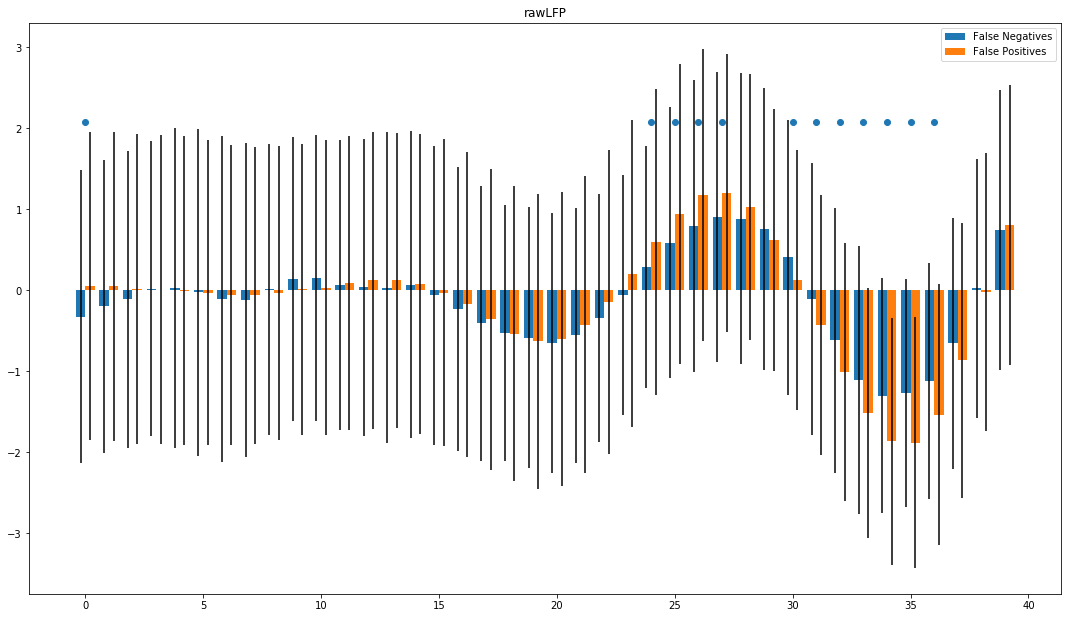

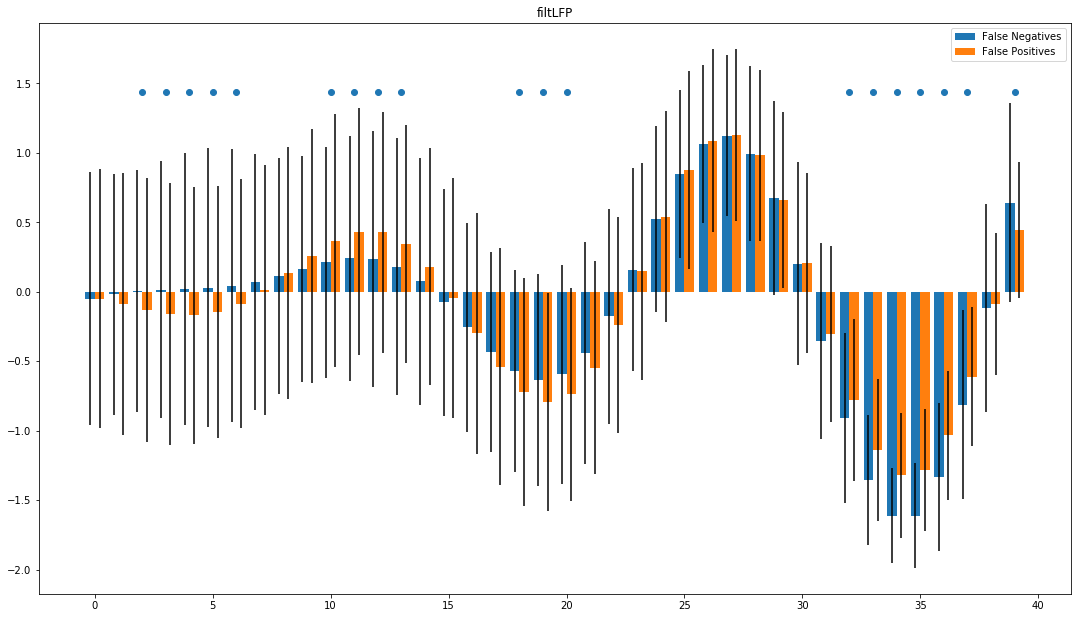

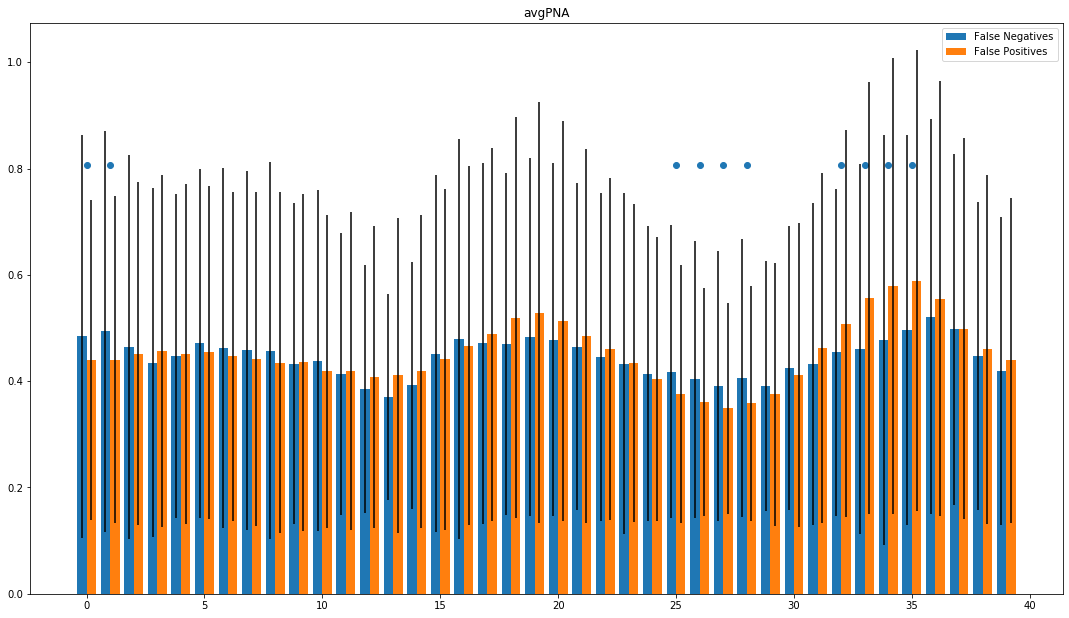

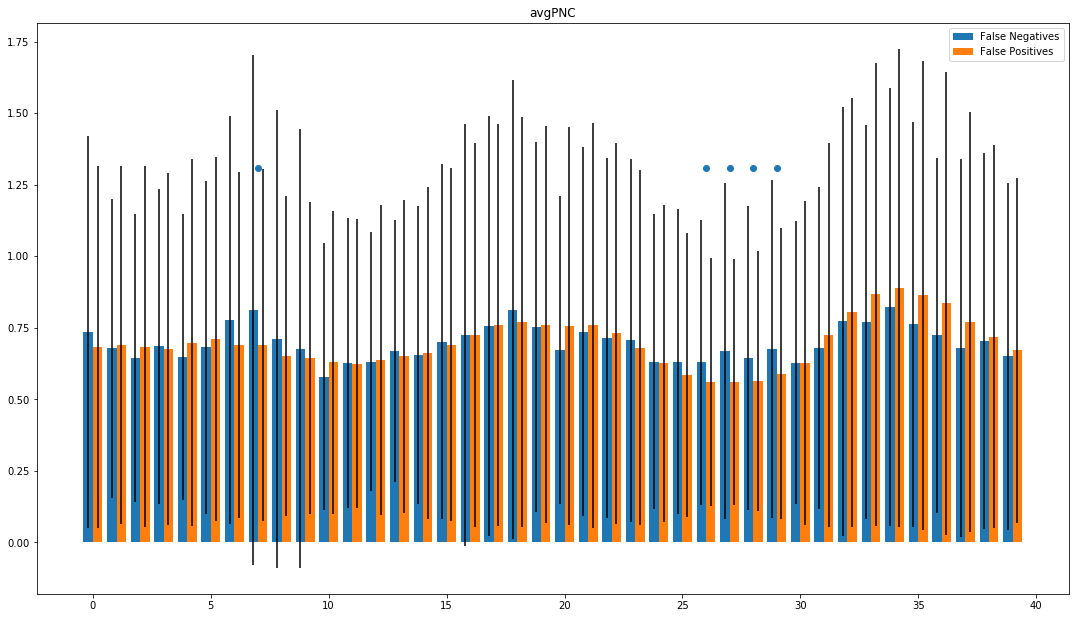

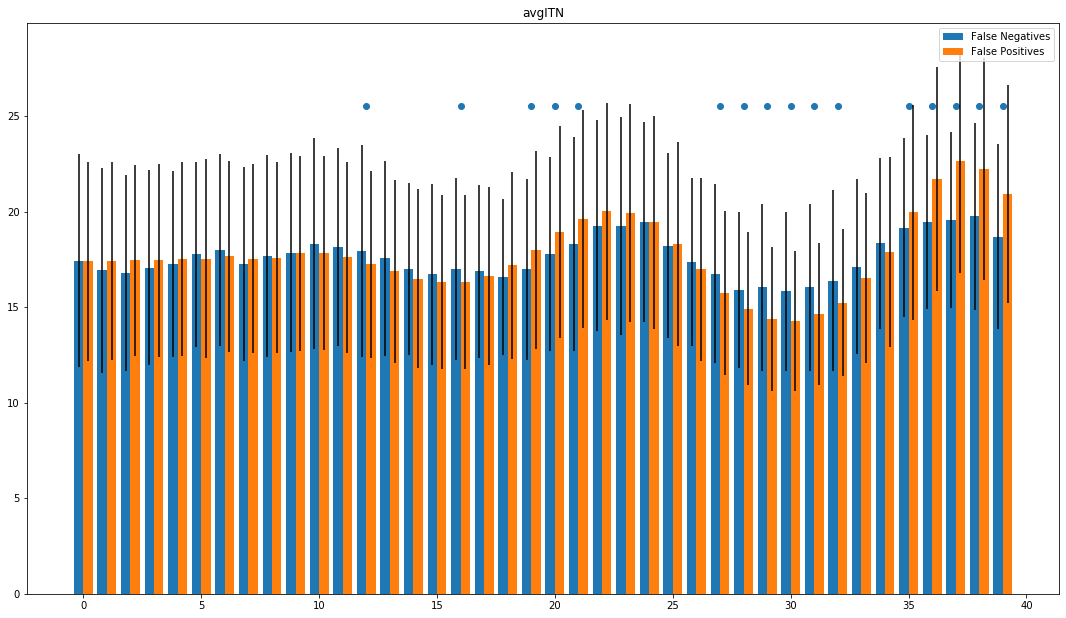

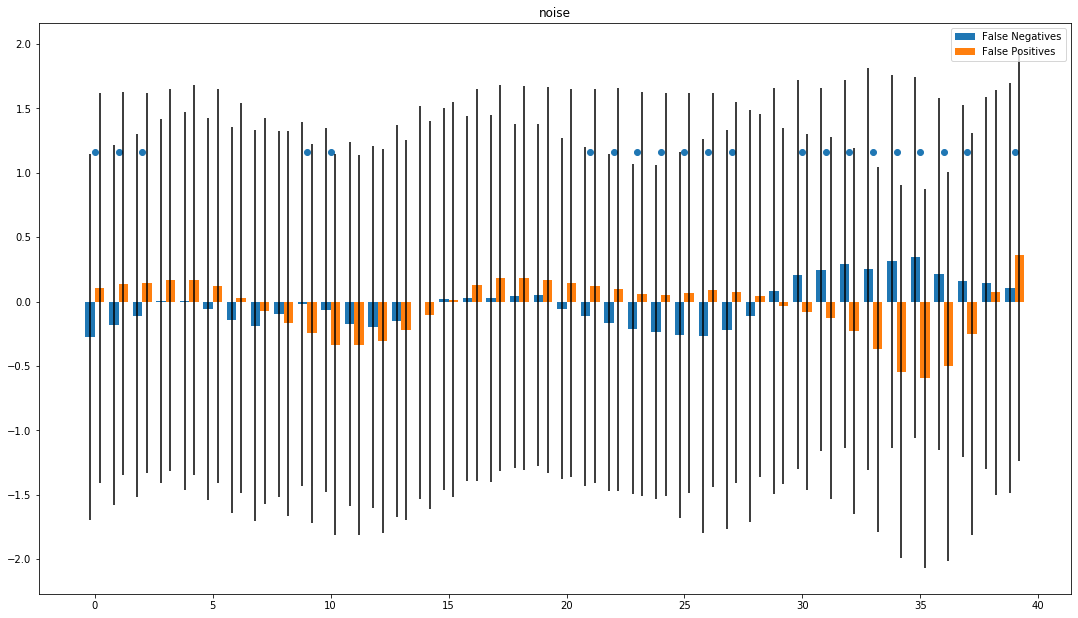

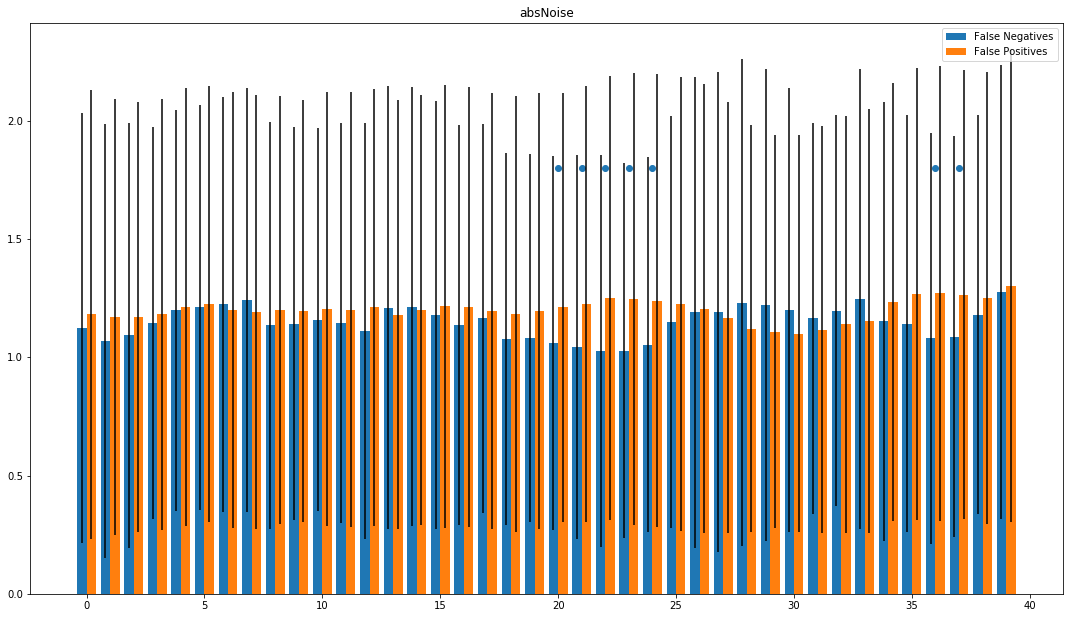

True Negatives vs. False Positives


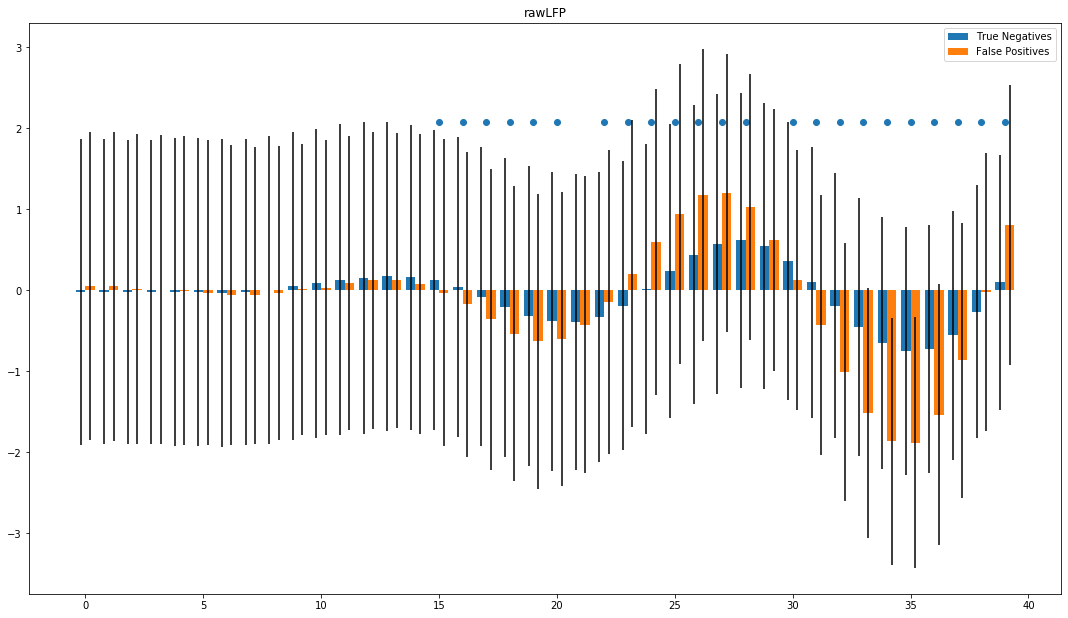

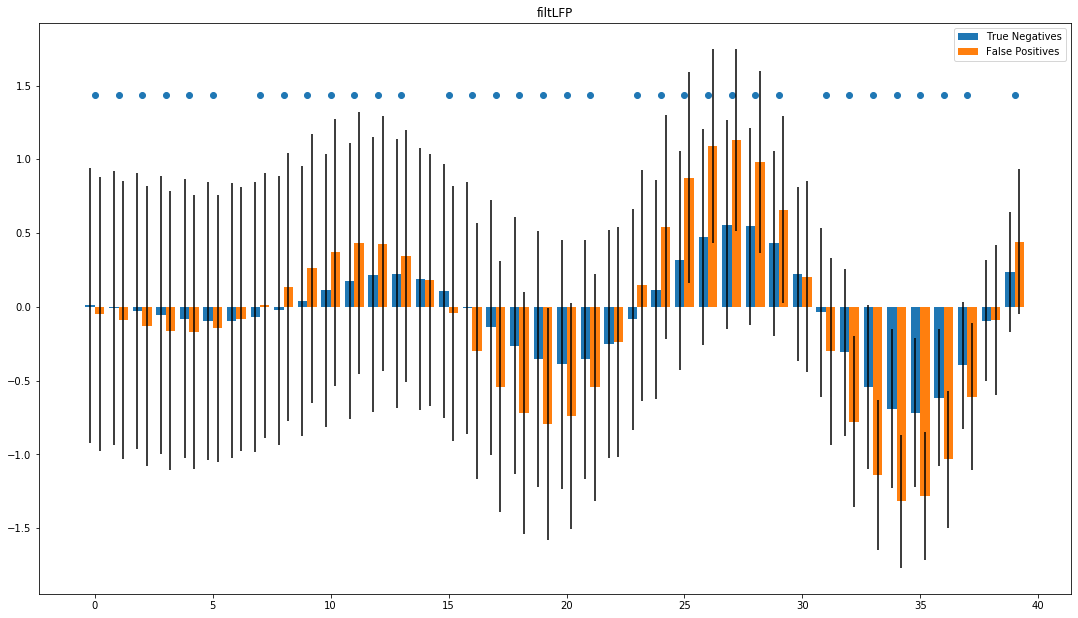

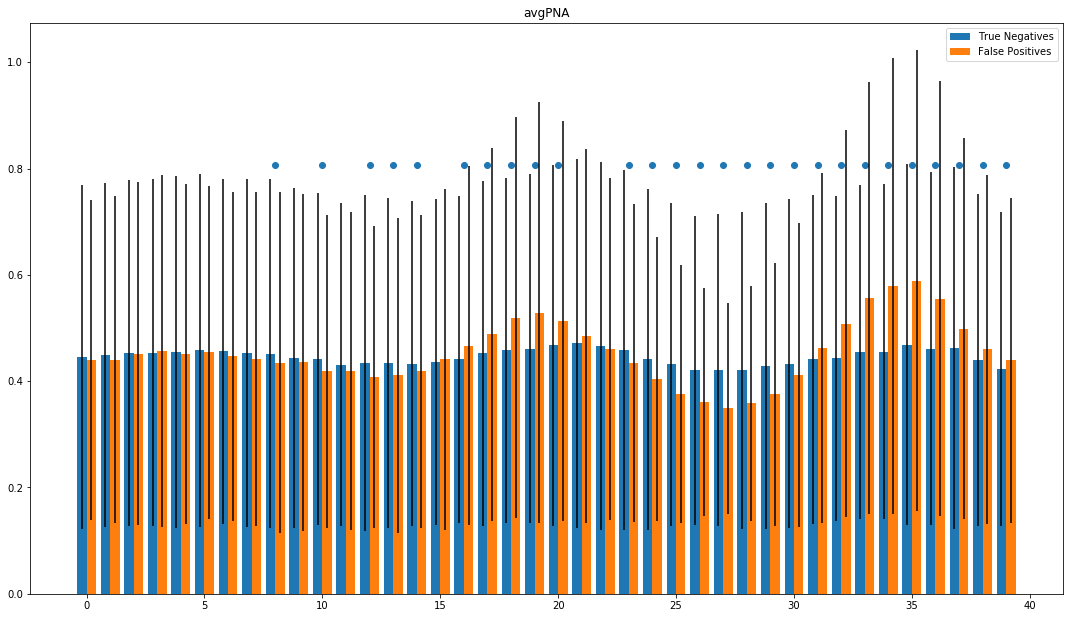

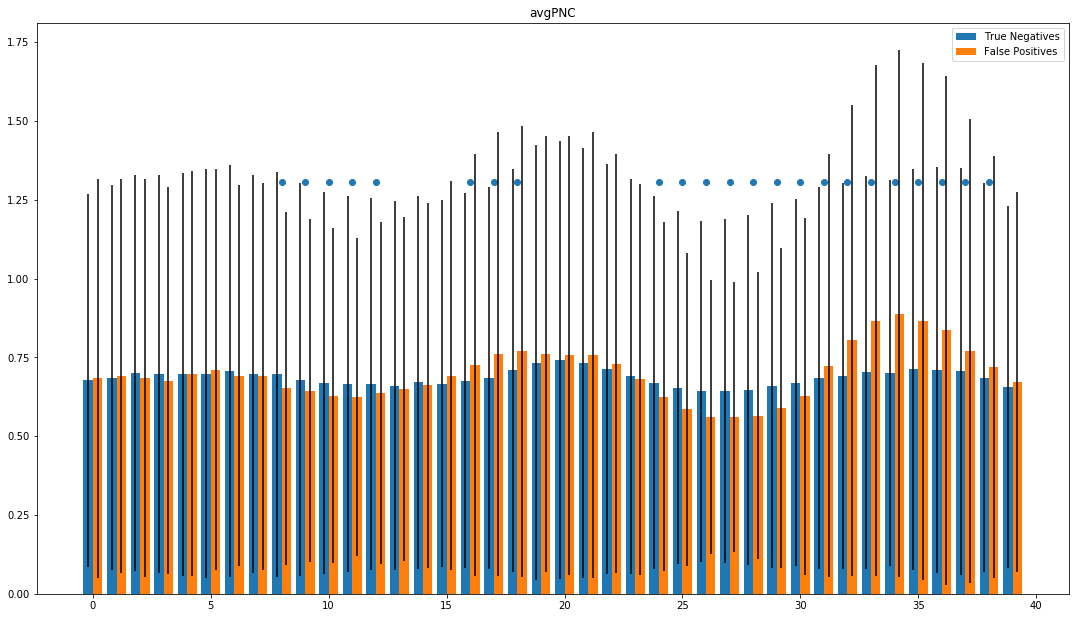

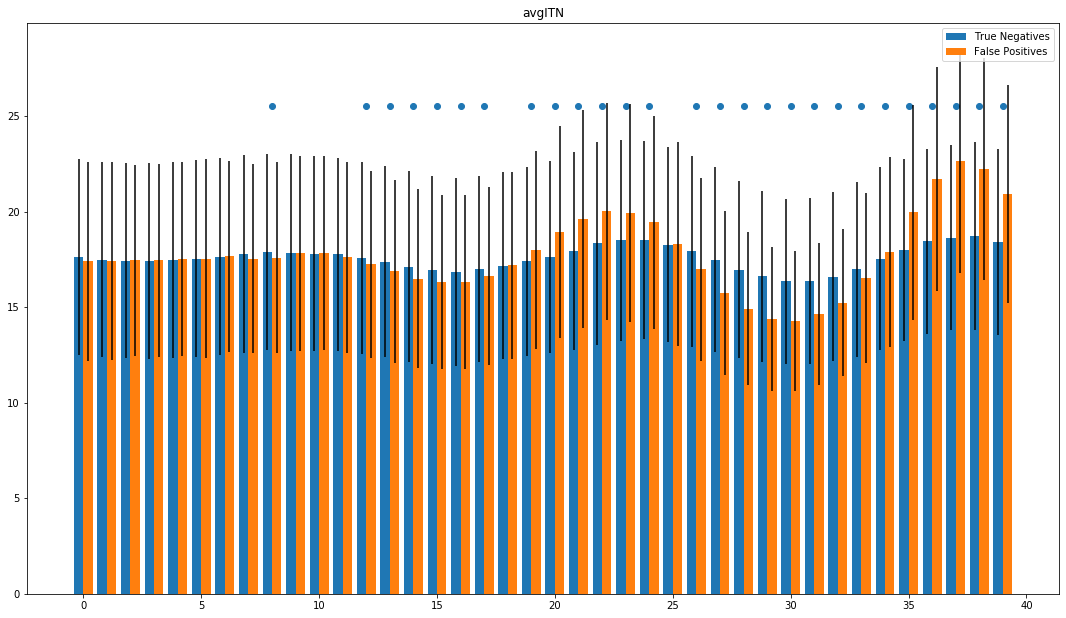

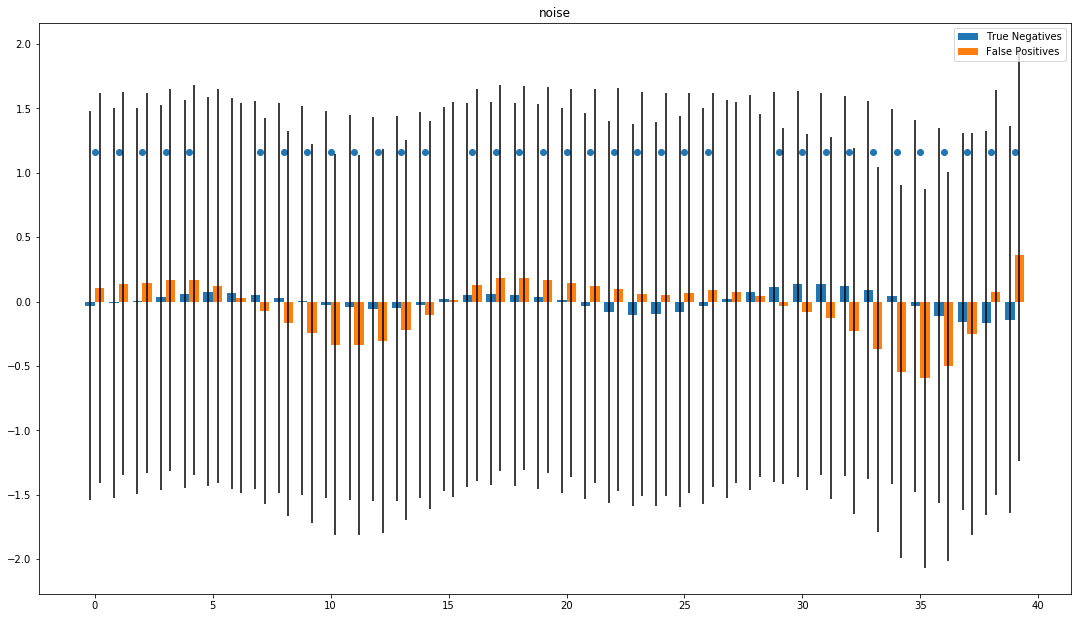

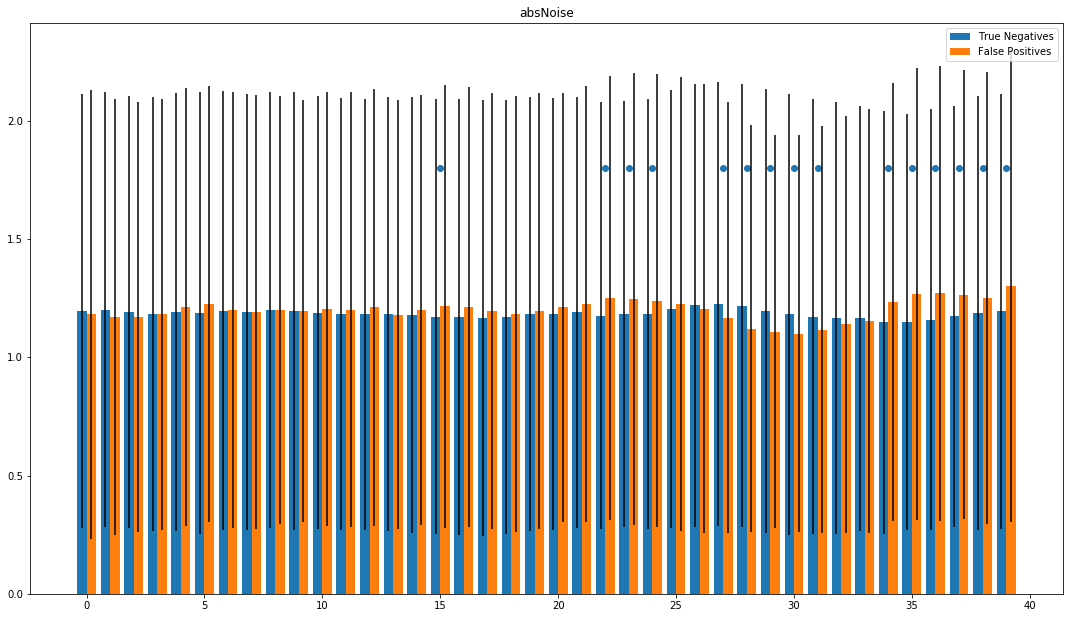

In [154]:
for n in range(4):
    for n2 in range(n + 1, 4):
        print(names[n], "vs.", names[n2])
        for feat in relevant:
            p_values = [f_oneway(datas[n][:, i, feat], datas[n2][:, i, feat]) for i in range(40)]
            stars= []
            for i in range(40):
                if p_values[i][1] < 0.05:
                    height = max(max(means[n, :, feat] + 0.5 * stds[n, :, feat]), max(means[n2, :, feat] + 0.5 * stds[n2, :, feat]))
                    stars.append(height)
                else:
                    stars.append(np.nan)

            fig, ax = plt.subplots()
            fig.set_size_inches(18.5, 10.5)
            ax.set_title(cols[feat])
            bar_plot(ax, {names[n]: means[n, :, feat], names[n2]:means[n2, :,feat]}, [stds[n, :, feat], stds[n2, :, feat]])
            plt.scatter(np.arange(0, 40), stars)
            plt.show()

### Plotted Averages

Raw LFP

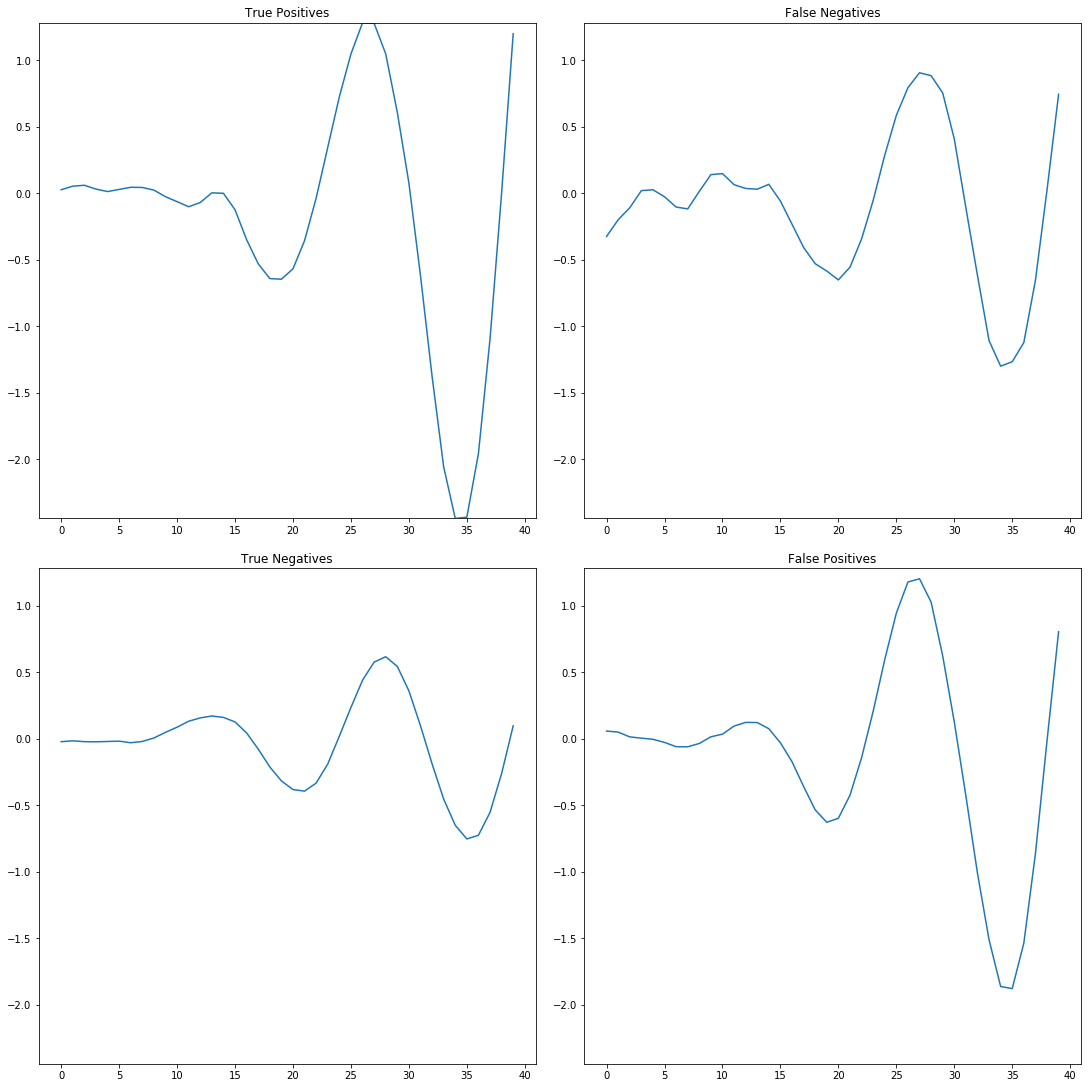

In [60]:
feat = 15
fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
count = 0
for ax in axs.flat:
    ax.set_title(names[count])
    ax.set_ylim([min([disp[i][:, :, feat].mean(0).min() for i in range(len(disp))])
        , max([disp[i][:, :, feat].mean(0).max() for i in range(len(disp))])])
    ax.plot(disp[count].mean(0)[:, feat])
    count += 1
plt.show()

AVG ITNs

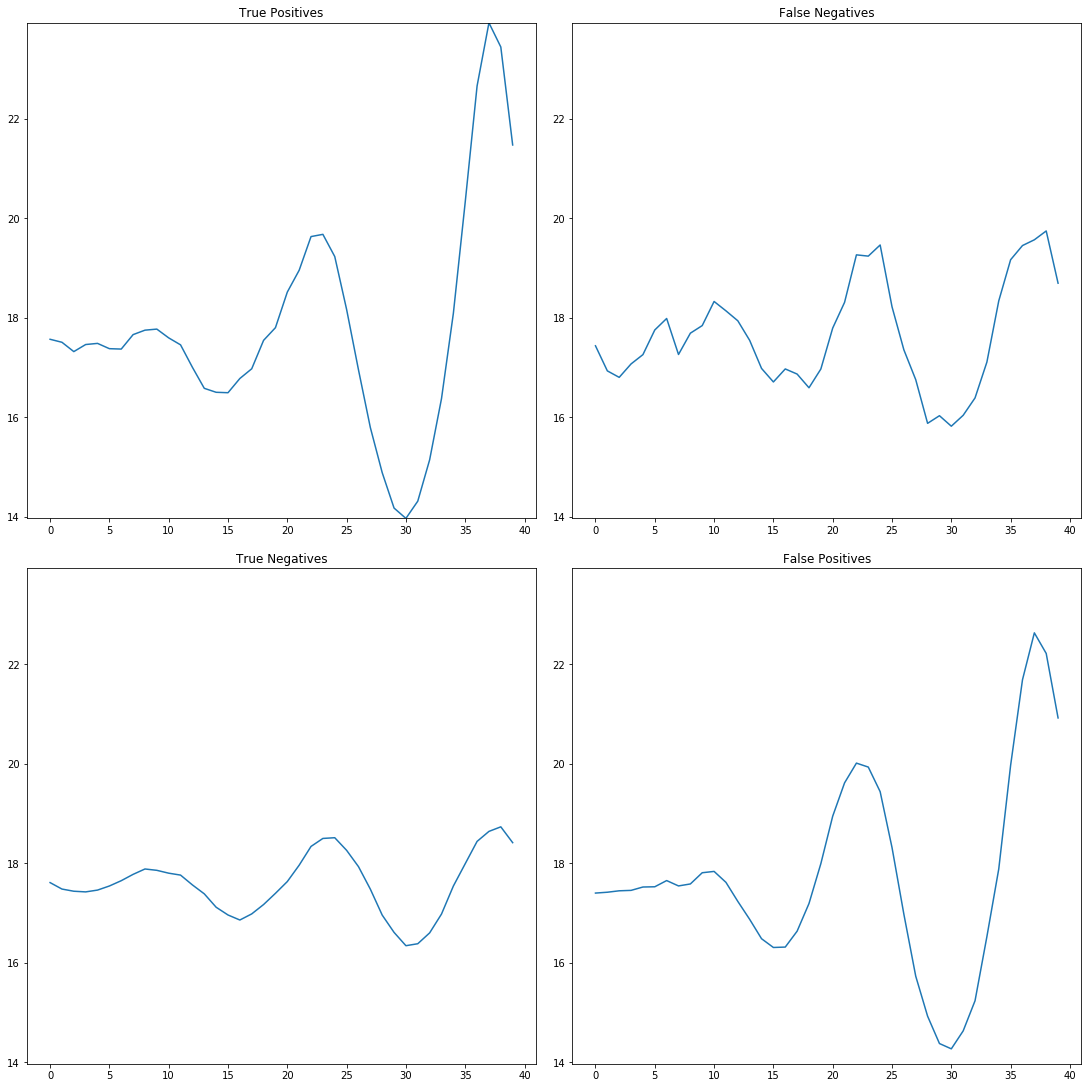

In [61]:
feat = -1
fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
count = 0
for ax in axs.flat:
    ax.set_title(names[count])
    ax.set_ylim([min([disp[i][:, :, feat].mean(0).min() for i in range(len(disp))])
        , max([disp[i][:, :, feat].mean(0).max() for i in range(len(disp))])])
    ax.plot(disp[count].mean(0)[:, feat])
    count += 1
plt.show()

AVG PNAs

In [85]:
f_p_values = [f_oneway(tn_data[:, i, 15], fn_data[:, i, 15]) for i in range(40)]

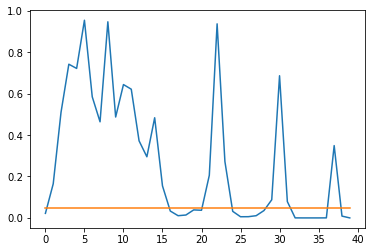

In [86]:
plt.plot([f_p_values[i][1] for i in range(40)])
plt.plot([0.05 for i in range(40)])

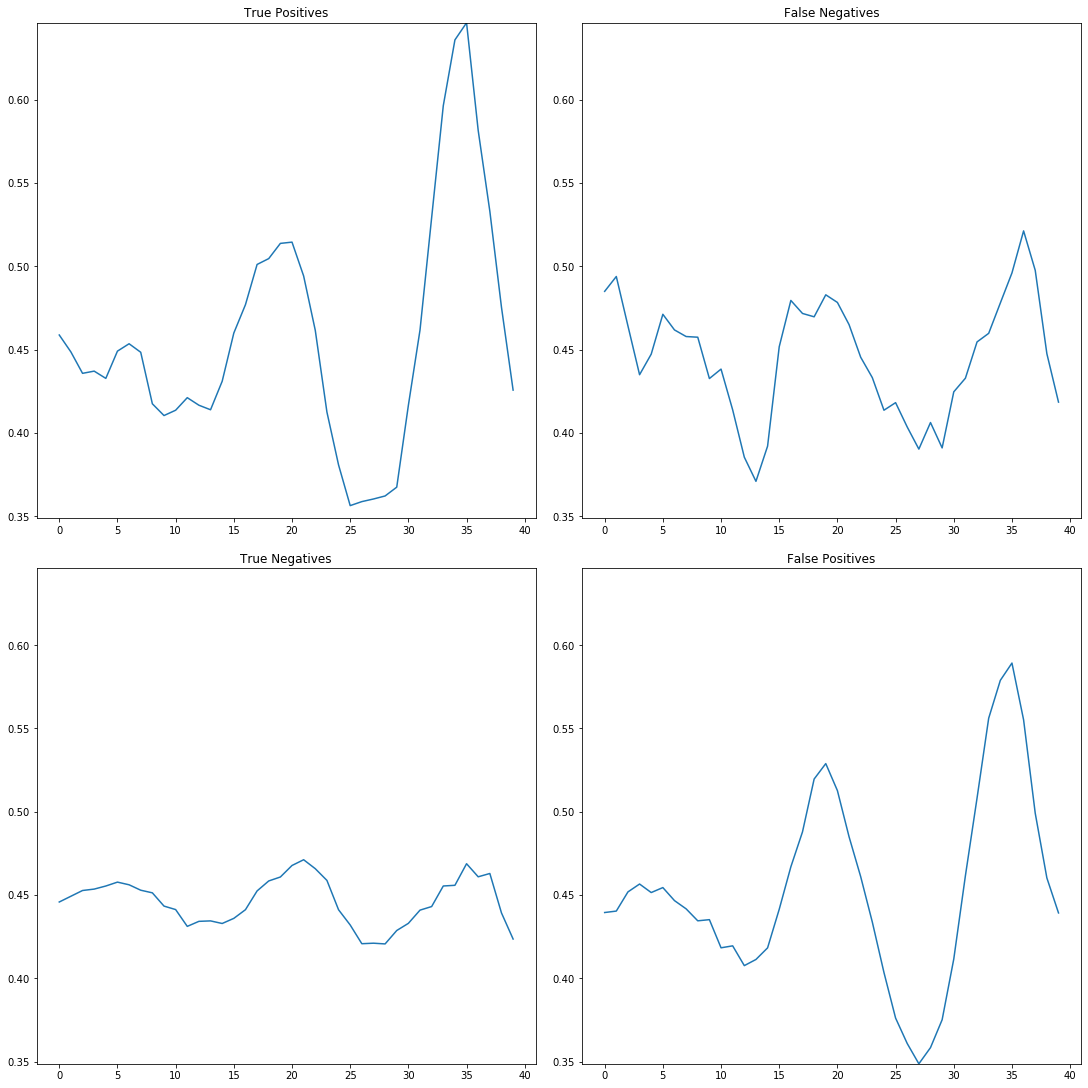

In [62]:
feat = -3
fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
count = 0
for ax in axs.flat:
    ax.set_title(names[count])
    ax.set_ylim([min([disp[i][:, :, feat].mean(0).min() for i in range(len(disp))])
        , max([disp[i][:, :, feat].mean(0).max() for i in range(len(disp))])])
    ax.plot(disp[count].mean(0)[:, feat])
    count += 1
plt.show()

AVG PNCs

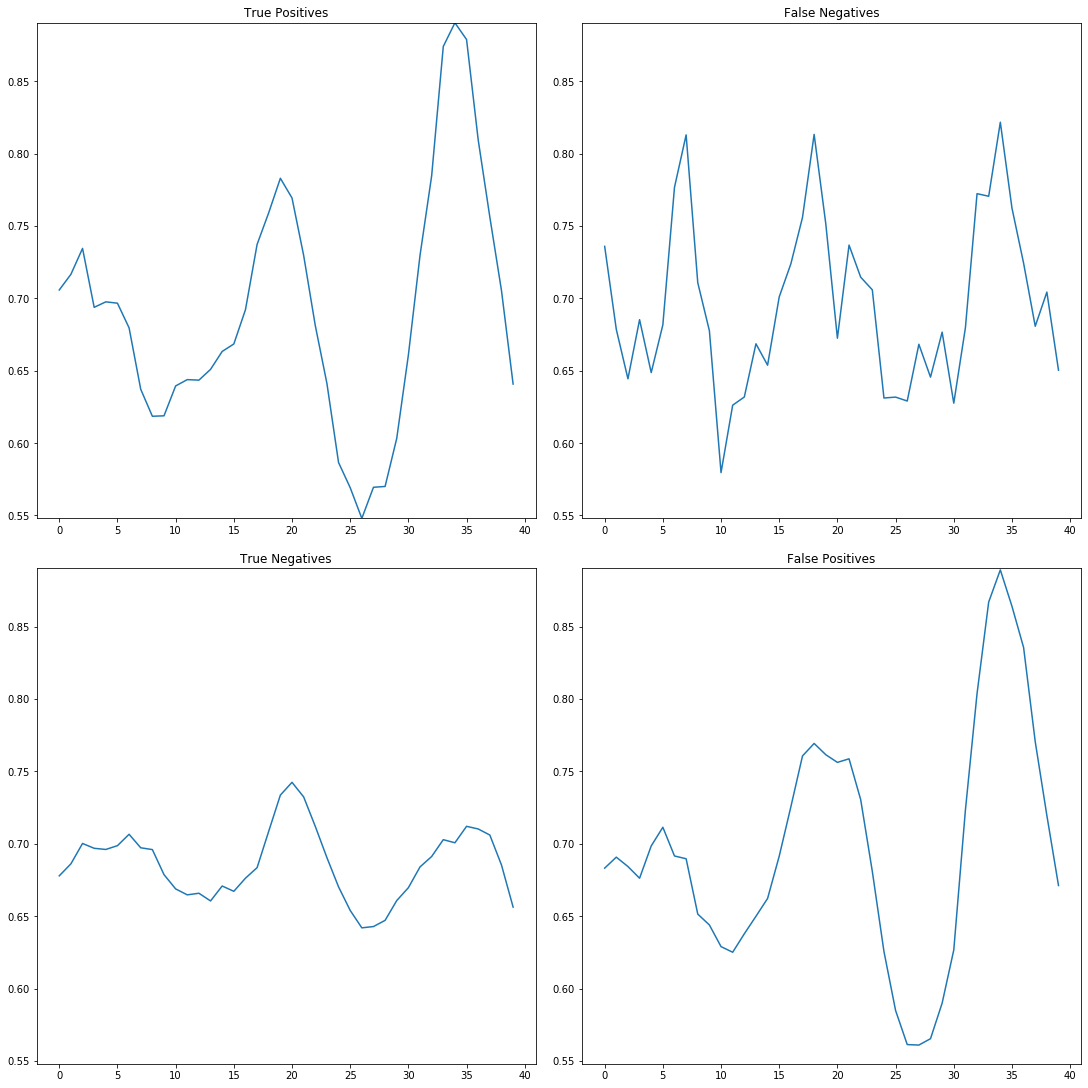

In [63]:
feat = -2
fig, axs = plt.subplots(2, 2, figsize=(15, 15), constrained_layout=True)
count = 0
for ax in axs.flat:
    ax.set_title(names[count])
    ax.set_ylim([min([disp[i][:, :, feat].mean(0).min() for i in range(len(disp))])
        , max([disp[i][:, :, feat].mean(0).max() for i in range(len(disp))])])
    ax.plot(disp[count].mean(0)[:, feat])
    count += 1
plt.show()

## GradCam

## Individual Filters/Features